### Importo le librerie

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
import os
from datetime import datetime
import itertools
import numpy as np
import pickle
import seaborn as sns
from scipy.interpolate import griddata

### Leggo i dati

In [27]:
dati = gpd.read_file('resa_girasole_2022.gpkg')
dati

Data/Ora  Longitudin  Latitudine  RESAKG  VELOCITA     AREA  \
0     5 set 2022, 10:08:09  11,9758245  44,8474908  1870.0      4.80  140.000   
1     5 set 2022, 10:08:24  11,9758157  44,8476751  1270.0      4.83  140.875   
2     5 set 2022, 10:08:40  11,9758154  44,8478795  1420.0      4.78  139.417   
3     5 set 2022, 10:08:55  11,9758209  44,8480593  2010.0      4.85  141.458   
4     5 set 2022, 10:09:10  11,9758201  44,8482443  1320.0      4.80  140.000   
...                    ...         ...         ...     ...       ...      ...   
1957  3 set 2022, 20:13:03  11,9757431  44,8480422  2260.0      4.77  139.125   
1958  3 set 2022, 20:13:19  11,9757395  44,8482399  2460.0      4.78  139.417   
1959  3 set 2022, 20:13:34  11,9757408  44,8484282  2330.0      4.78  139.417   
1960  3 set 2022, 20:13:49  11,9757414   44,848618  1950.0      4.99  145.542   
1961  3 set 2022, 20:14:05  11,9757344  44,8488297  1810.0      5.44  158.667   

      UMIDITA                         geometry  
0         NaN  POINT (1333142.685 5597543.903)  
1         NaN  POINT (1333141.706 5597572.841)  
2         NaN  POINT (1333141.672 5597604.934)  
3        33.1  POINT (1333142.284 5597633.165)  
4        33.1  POINT (1333142.195 5597662.213)  
...       ...                              ...  
1957     30.8  POINT (1333133.624 5597630.480)  
1958     24.6  POINT (1333133.223 5597661.522)  
1959     24.6  POINT (1333133.368 5597691.088)  
1960     24.6  POINT (1333133.435 5597720.889)  
1961     24.6  POINT (1333132.655 5597754.129)  

[1962 rows x 8 columns]

<h4> Rinomino alcune colonne </h4>

In [28]:
dati = dati.rename(columns={'Longitudin': 'Longitudine', 'RESAKG': 'Resa (kg)', 'VELOCITA': 'Velocità (km/h)', 'AREA': 'Area (m^2)', 'UMIDITA': 'Umidità (%)', 'geometry': 'Geometry'})
dati

Data/Ora Longitudine  Latitudine  Resa (kg)  \
0     5 set 2022, 10:08:09  11,9758245  44,8474908     1870.0   
1     5 set 2022, 10:08:24  11,9758157  44,8476751     1270.0   
2     5 set 2022, 10:08:40  11,9758154  44,8478795     1420.0   
3     5 set 2022, 10:08:55  11,9758209  44,8480593     2010.0   
4     5 set 2022, 10:09:10  11,9758201  44,8482443     1320.0   
...                    ...         ...         ...        ...   
1957  3 set 2022, 20:13:03  11,9757431  44,8480422     2260.0   
1958  3 set 2022, 20:13:19  11,9757395  44,8482399     2460.0   
1959  3 set 2022, 20:13:34  11,9757408  44,8484282     2330.0   
1960  3 set 2022, 20:13:49  11,9757414   44,848618     1950.0   
1961  3 set 2022, 20:14:05  11,9757344  44,8488297     1810.0   

      Velocità (km/h)  Area (m^2)  Umidità (%)  \
0                4.80     140.000          NaN   
1                4.83     140.875          NaN   
2                4.78     139.417          NaN   
3                4.85     141.458         33.1   
4                4.80     140.000         33.1   
...               ...         ...          ...   
1957             4.77     139.125         30.8   
1958             4.78     139.417         24.6   
1959             4.78     139.417         24.6   
1960             4.99     145.542         24.6   
1961             5.44     158.667         24.6   

                             Geometry  
0     POINT (1333142.685 5597543.903)  
1     POINT (1333141.706 5597572.841)  
2     POINT (1333141.672 5597604.934)  
3     POINT (1333142.284 5597633.165)  
4     POINT (1333142.195 5597662.213)  
...                               ...  
1957  POINT (1333133.624 5597630.480)  
1958  POINT (1333133.223 5597661.522)  
1959  POINT (1333133.368 5597691.088)  
1960  POINT (1333133.435 5597720.889)  
1961  POINT (1333132.655 5597754.129)  

[1962 rows x 8 columns]

### EDA (Exploratory Data Analysis)

#### Guardo quanti sono i dati mancanti in ogni colonna

In [29]:
dati.isnull().sum()

Data/Ora            0
Longitudine         0
Latitudine          0
Resa (kg)           0
Velocità (km/h)     0
Area (m^2)          0
Umidità (%)        37
Geometry            0
dtype: int64

#### Guardo quali sono i tipi delle colonne e ne cambio alcuni

In [30]:
dati.dtypes

Data/Ora             object
Longitudine          object
Latitudine           object
Resa (kg)           float64
Velocità (km/h)     float64
Area (m^2)          float64
Umidità (%)         float64
Geometry           geometry
dtype: object

In [31]:
# Adatto i mesi in italiano a quello che serve in inglese affinchè Pandas possa fare la conversione in datetime (ad esempio 'set' diventa 'Sep')

italian_to_english_month = {
    'gen': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'apr': 'Apr',
    'mag': 'May',
    'giu': 'Jun',
    'lug': 'Jul',
    'ago': 'Aug',
    'set': 'Sep',
    'ott': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Converto il formato della data in un formato riconosciuto da Pandas
dati['Data/Ora'] = dati['Data/Ora'].str.split().apply(lambda x: ' '.join([x[0], italian_to_english_month[x[1].lower()], x[2], x[3]]))
dati['Data/Ora'] = pd.to_datetime(dati['Data/Ora'], format='%d %b %Y, %H:%M:%S')

# Converto le colonne 'Longitudine' e 'Latitudine' in float
dati['Longitudine'] = dati['Longitudine'].str.replace(',', '.').astype(float)
dati['Latitudine'] = dati['Latitudine'].str.replace(',', '.').astype(float)

In [32]:
dati.dtypes

Data/Ora           datetime64[ns]
Longitudine               float64
Latitudine                float64
Resa (kg)                 float64
Velocità (km/h)           float64
Area (m^2)                float64
Umidità (%)               float64
Geometry                 geometry
dtype: object

In [33]:
dati

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0    2022-09-05 10:08:09    11.975824   44.847491     1870.0             4.80   
1    2022-09-05 10:08:24    11.975816   44.847675     1270.0             4.83   
2    2022-09-05 10:08:40    11.975815   44.847879     1420.0             4.78   
3    2022-09-05 10:08:55    11.975821   44.848059     2010.0             4.85   
4    2022-09-05 10:09:10    11.975820   44.848244     1320.0             4.80   
...                  ...          ...         ...        ...              ...   
1957 2022-09-03 20:13:03    11.975743   44.848042     2260.0             4.77   
1958 2022-09-03 20:13:19    11.975739   44.848240     2460.0             4.78   
1959 2022-09-03 20:13:34    11.975741   44.848428     2330.0             4.78   
1960 2022-09-03 20:13:49    11.975741   44.848618     1950.0             4.99   
1961 2022-09-03 20:14:05    11.975734   44.848830     1810.0             5.44   

      Area (m^2)  Umidità (%)                         Geometry  
0        140.000          NaN  POINT (1333142.685 5597543.903)  
1        140.875          NaN  POINT (1333141.706 5597572.841)  
2        139.417          NaN  POINT (1333141.672 5597604.934)  
3        141.458         33.1  POINT (1333142.284 5597633.165)  
4        140.000         33.1  POINT (1333142.195 5597662.213)  
...          ...          ...                              ...  
1957     139.125         30.8  POINT (1333133.624 5597630.480)  
1958     139.417         24.6  POINT (1333133.223 5597661.522)  
1959     139.417         24.6  POINT (1333133.368 5597691.088)  
1960     145.542         24.6  POINT (1333133.435 5597720.889)  
1961     158.667         24.6  POINT (1333132.655 5597754.129)  

[1962 rows x 8 columns]

#### Riordino il dataset in base alla data

In [34]:
dati = dati.sort_values(by='Data/Ora').reset_index(drop=True)
dati

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0    2022-08-31 16:26:24    11.964918   44.850943     1430.0             3.91   
1    2022-08-31 16:26:39    11.964952   44.850793     1240.0             4.71   
2    2022-08-31 16:26:55    11.964934   44.850615     2190.0             4.72   
3    2022-08-31 16:27:10    11.964928   44.850444     2260.0             4.12   
4    2022-08-31 16:27:25    11.964940   44.850285     2680.0             4.09   
...                  ...          ...         ...        ...              ...   
1957 2022-09-05 12:22:12    11.978069   44.847548     2950.0             4.87   
1958 2022-09-05 12:22:28    11.978069   44.847751     3150.0             4.78   
1959 2022-09-05 12:22:43    11.978063   44.847956     2570.0             5.35   
1960 2022-09-05 12:22:58    11.978056   44.848153     3240.0             5.36   
1961 2022-09-05 12:23:14    11.978053   44.848373     3200.0             5.37   

      Area (m^2)  Umidità (%)                         Geometry  
0        114.042         36.8  POINT (1331928.635 5598085.894)  
1        137.375         36.8  POINT (1331932.375 5598062.435)  
2        137.667         36.8  POINT (1331930.305 5598034.501)  
3        120.167         36.8  POINT (1331929.715 5598007.541)  
4        119.292         25.7  POINT (1331931.017 5597982.716)  
...          ...          ...                              ...  
1957     142.042         19.5  POINT (1333392.520 5597552.900)  
1958     139.417         19.5  POINT (1333392.564 5597584.805)  
1959     156.042         19.4  POINT (1333391.896 5597616.898)  
1960     156.333         19.4  POINT (1333391.106 5597647.814)  
1961     156.625         19.4  POINT (1333390.761 5597682.358)  

[1962 rows x 8 columns]

#### Analizzo alcune statistiche del dataset

In [35]:
def describex(dati):
    dati = pd.DataFrame(dati)
    stats = dati.describe(percentiles=[0.01,0.25,0.5,0.75,0.90,0.95,0.99])
    skewness = dati.skew()
    kurtosis = dati.kurtosis()
    skewness_df = pd.DataFrame({'skewness' : skewness}).T
    kurtosis_df = pd.DataFrame({'kurtosis' : kurtosis}).T
    mediane = dati.median()
    mediane_df = pd.DataFrame({'mediane' : mediane}).T
    valori_missing = pd.DataFrame({'valori missing': dati.isna().sum()}).T
    percentuale_missing = ((dati.isna().sum() / len(dati) * 100).round(2)).apply(lambda x: f'{x}%')
    percentuale_missing_df = pd.DataFrame({'percentuale missing': percentuale_missing}).T
    valori_unici = pd.DataFrame({'valori_unici':dati.nunique()}).T
    return pd.concat([stats, kurtosis_df, skewness_df, mediane_df, valori_missing, percentuale_missing_df, valori_unici])

In [36]:
describex(dati)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16956\3047461494.py:4: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = dati.skew()
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16956\3047461494.py:5: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  kurtosis = dati.kurtosis()
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16956\3047461494.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mediane = dati.median()
C:\Users

Longitudine Latitudine    Resa (kg) Velocità (km/h)  \
count                    1962.0     1962.0       1962.0          1962.0   
mean                  11.971261  44.848606  2255.285423        4.903976   
std                     0.00432   0.000848   699.827651        0.614924   
min                   11.964918  44.847392         50.0            0.78   
1%                    11.964978  44.847417        364.4          3.5066   
25%                    11.96769  44.847884       1792.5            4.57   
50%                   11.970551  44.848464       2300.0             4.9   
75%                   11.974281  44.849207       2730.0            5.18   
90%                    11.97762  44.849845       3110.0            5.59   
95%                   11.979299  44.850197       3309.5            5.89   
99%                   11.981662  44.850659       3763.9          6.6117   
max                   11.983093  44.850986       4880.0           10.91   
kurtosis              -0.580732  -0.566013     0.184506       10.373969   
skewness                0.53654   0.567423    -0.283731         0.36888   
mediane               11.970551  44.848464       2300.0             4.9   
valori missing                0          0            0               0   
percentuale missing        0.0%       0.0%         0.0%            0.0%   
valori_unici               1945       1883          332             296   

                     Area (m^2) Umidità (%) Data/Ora Geometry  
count                    1962.0      1925.0      NaN      NaN  
mean                 143.032629   27.022805      NaN      NaN  
std                   17.935293    6.154021      NaN      NaN  
min                       22.75        18.6      NaN      NaN  
1%                     102.2755        19.0      NaN      NaN  
25%                     133.292        22.2      NaN      NaN  
50%                     142.917        25.8      NaN      NaN  
75%                     151.083        30.2      NaN      NaN  
90%                     163.042        36.0      NaN      NaN  
95%                     171.792       39.14      NaN      NaN  
99%                   192.84125        45.2      NaN      NaN  
max                     318.208        50.1      NaN      NaN  
kurtosis              10.373918     0.86432      NaN      NaN  
skewness               0.368875    1.045134      NaN      NaN  
mediane                 142.917        25.8      NaN      NaN  
valori missing                0          37        0        0  
percentuale missing        0.0%       1.89%     0.0%     0.0%  
valori_unici                296         208     1962     1962

### Inputing dei dati mancanti

In [37]:
def riempi_nan_con_mediana(df):

    df_copia = df.copy()
    
    for colonna in df_copia.columns:
        tipo_colonna = pd.api.types.infer_dtype(df_copia[colonna])
        if tipo_colonna in ['integer', 'floating']:
            # Per le colonne numeriche (e non bool o complex), calcolo la mediana e riempio i NaN con la mediana
            mediana_colonna = df_copia[colonna].median()
            df_copia[colonna] = df_copia[colonna].fillna(mediana_colonna)
        else:
            # Per le colonne non numeriche (inclusi però bool e complex, che qui non ci sono), riempio i NaN con la stringa "Missing"
            df_copia[colonna] = df_copia[colonna].fillna("Missing")
    return df_copia

df_senza_valori_nan = riempi_nan_con_mediana(dati)

In [38]:
# Mostro che non ci sono più valori NaN
df_senza_valori_nan.isna().sum()

Data/Ora           0
Longitudine        0
Latitudine         0
Resa (kg)          0
Velocità (km/h)    0
Area (m^2)         0
Umidità (%)        0
Geometry           0
dtype: int64

In [39]:
df_senza_valori_nan

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0    2022-08-31 16:26:24    11.964918   44.850943     1430.0             3.91   
1    2022-08-31 16:26:39    11.964952   44.850793     1240.0             4.71   
2    2022-08-31 16:26:55    11.964934   44.850615     2190.0             4.72   
3    2022-08-31 16:27:10    11.964928   44.850444     2260.0             4.12   
4    2022-08-31 16:27:25    11.964940   44.850285     2680.0             4.09   
...                  ...          ...         ...        ...              ...   
1957 2022-09-05 12:22:12    11.978069   44.847548     2950.0             4.87   
1958 2022-09-05 12:22:28    11.978069   44.847751     3150.0             4.78   
1959 2022-09-05 12:22:43    11.978063   44.847956     2570.0             5.35   
1960 2022-09-05 12:22:58    11.978056   44.848153     3240.0             5.36   
1961 2022-09-05 12:23:14    11.978053   44.848373     3200.0             5.37   

      Area (m^2)  Umidità (%)                         Geometry  
0        114.042         36.8  POINT (1331928.635 5598085.894)  
1        137.375         36.8  POINT (1331932.375 5598062.435)  
2        137.667         36.8  POINT (1331930.305 5598034.501)  
3        120.167         36.8  POINT (1331929.715 5598007.541)  
4        119.292         25.7  POINT (1331931.017 5597982.716)  
...          ...          ...                              ...  
1957     142.042         19.5  POINT (1333392.520 5597552.900)  
1958     139.417         19.5  POINT (1333392.564 5597584.805)  
1959     156.042         19.4  POINT (1333391.896 5597616.898)  
1960     156.333         19.4  POINT (1333391.106 5597647.814)  
1961     156.625         19.4  POINT (1333390.761 5597682.358)  

[1962 rows x 8 columns]

### Raggruppamento dei dati in dataset diversi in base al giorno di raccolta

In [40]:
lista_dataset_per_giorno = [gruppo for data, gruppo in dati.groupby(dati['Data/Ora'].dt.date)]
len(lista_dataset_per_giorno)

3

In [41]:
dati0 = lista_dataset_per_giorno[0]
dati0

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0   2022-08-31 16:26:24    11.964918   44.850943     1430.0             3.91   
1   2022-08-31 16:26:39    11.964952   44.850793     1240.0             4.71   
2   2022-08-31 16:26:55    11.964934   44.850615     2190.0             4.72   
3   2022-08-31 16:27:10    11.964928   44.850444     2260.0             4.12   
4   2022-08-31 16:27:25    11.964940   44.850285     2680.0             4.09   
..                  ...          ...         ...        ...              ...   
185 2022-08-31 17:40:02    11.965812   44.850055     2440.0             4.88   
186 2022-08-31 17:40:18    11.965807   44.850260     2420.0             4.95   
187 2022-08-31 17:40:33    11.965798   44.850444     2560.0             4.96   
188 2022-08-31 17:40:48    11.965801   44.850632     2660.0             4.96   
189 2022-08-31 17:41:04    11.965798   44.850833     2710.0             4.89   

     Area (m^2)  Umidità (%)                         Geometry  
0       114.042         36.8  POINT (1331928.635 5598085.894)  
1       137.375         36.8  POINT (1331932.375 5598062.435)  
2       137.667         36.8  POINT (1331930.305 5598034.501)  
3       120.167         36.8  POINT (1331929.715 5598007.541)  
4       119.292         25.7  POINT (1331931.017 5597982.716)  
..          ...          ...                              ...  
185     142.333         30.4  POINT (1332028.065 5597946.554)  
186     144.375         30.4  POINT (1332027.498 5597978.680)  
187     144.667         26.5  POINT (1332026.551 5598007.588)  
188     144.667         26.5  POINT (1332026.863 5598037.170)  
189     142.625         26.5  POINT (1332026.507 5598068.637)  

[190 rows x 8 columns]

In [42]:
dati1 = lista_dataset_per_giorno[1]
dati1

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
190  2022-09-03 10:07:15    11.965870   44.850832     2000.0             4.53   
191  2022-09-03 10:07:30    11.965874   44.850663     3410.0             4.41   
192  2022-09-03 11:03:30    11.965894   44.849729     1970.0             5.22   
193  2022-09-03 11:03:45    11.965898   44.849525     2790.0             5.16   
194  2022-09-03 11:04:00    11.965900   44.849321     2100.0             5.27   
...                  ...          ...         ...        ...              ...   
1640 2022-09-03 20:13:03    11.975743   44.848042     2260.0             4.77   
1641 2022-09-03 20:13:19    11.975739   44.848240     2460.0             4.78   
1642 2022-09-03 20:13:34    11.975741   44.848428     2330.0             4.78   
1643 2022-09-03 20:13:49    11.975741   44.848618     1950.0             4.99   
1644 2022-09-03 20:14:05    11.975734   44.848830     1810.0             5.44   

      Area (m^2)  Umidità (%)                         Geometry  
190      132.125          NaN  POINT (1332034.522 5598068.512)  
191      128.625          NaN  POINT (1332034.978 5598041.944)  
192      152.250         24.5  POINT (1332037.182 5597895.319)  
193      150.500         24.5  POINT (1332037.628 5597863.334)  
194      153.708         24.5  POINT (1332037.939 5597831.271)  
...          ...          ...                              ...  
1640     139.125         30.8  POINT (1333133.624 5597630.480)  
1641     139.417         24.6  POINT (1333133.223 5597661.522)  
1642     139.417         24.6  POINT (1333133.368 5597691.088)  
1643     145.542         24.6  POINT (1333133.435 5597720.889)  
1644     158.667         24.6  POINT (1333132.655 5597754.129)  

[1455 rows x 8 columns]

In [43]:
dati2 = lista_dataset_per_giorno[2]
dati2

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
1645 2022-09-05 10:08:09    11.975824   44.847491     1870.0             4.80   
1646 2022-09-05 10:08:24    11.975816   44.847675     1270.0             4.83   
1647 2022-09-05 10:08:40    11.975815   44.847879     1420.0             4.78   
1648 2022-09-05 10:08:55    11.975821   44.848059     2010.0             4.85   
1649 2022-09-05 10:09:10    11.975820   44.848244     1320.0             4.80   
...                  ...          ...         ...        ...              ...   
1957 2022-09-05 12:22:12    11.978069   44.847548     2950.0             4.87   
1958 2022-09-05 12:22:28    11.978069   44.847751     3150.0             4.78   
1959 2022-09-05 12:22:43    11.978063   44.847956     2570.0             5.35   
1960 2022-09-05 12:22:58    11.978056   44.848153     3240.0             5.36   
1961 2022-09-05 12:23:14    11.978053   44.848373     3200.0             5.37   

      Area (m^2)  Umidità (%)                         Geometry  
1645     140.000          NaN  POINT (1333142.685 5597543.903)  
1646     140.875          NaN  POINT (1333141.706 5597572.841)  
1647     139.417          NaN  POINT (1333141.672 5597604.934)  
1648     141.458         33.1  POINT (1333142.284 5597633.165)  
1649     140.000         33.1  POINT (1333142.195 5597662.213)  
...          ...          ...                              ...  
1957     142.042         19.5  POINT (1333392.520 5597552.900)  
1958     139.417         19.5  POINT (1333392.564 5597584.805)  
1959     156.042         19.4  POINT (1333391.896 5597616.898)  
1960     156.333         19.4  POINT (1333391.106 5597647.814)  
1961     156.625         19.4  POINT (1333390.761 5597682.358)  

[317 rows x 8 columns]

### Grafici

#### Grafici in funzione del tempo

##### Gruppo 1 (31/08/2022)

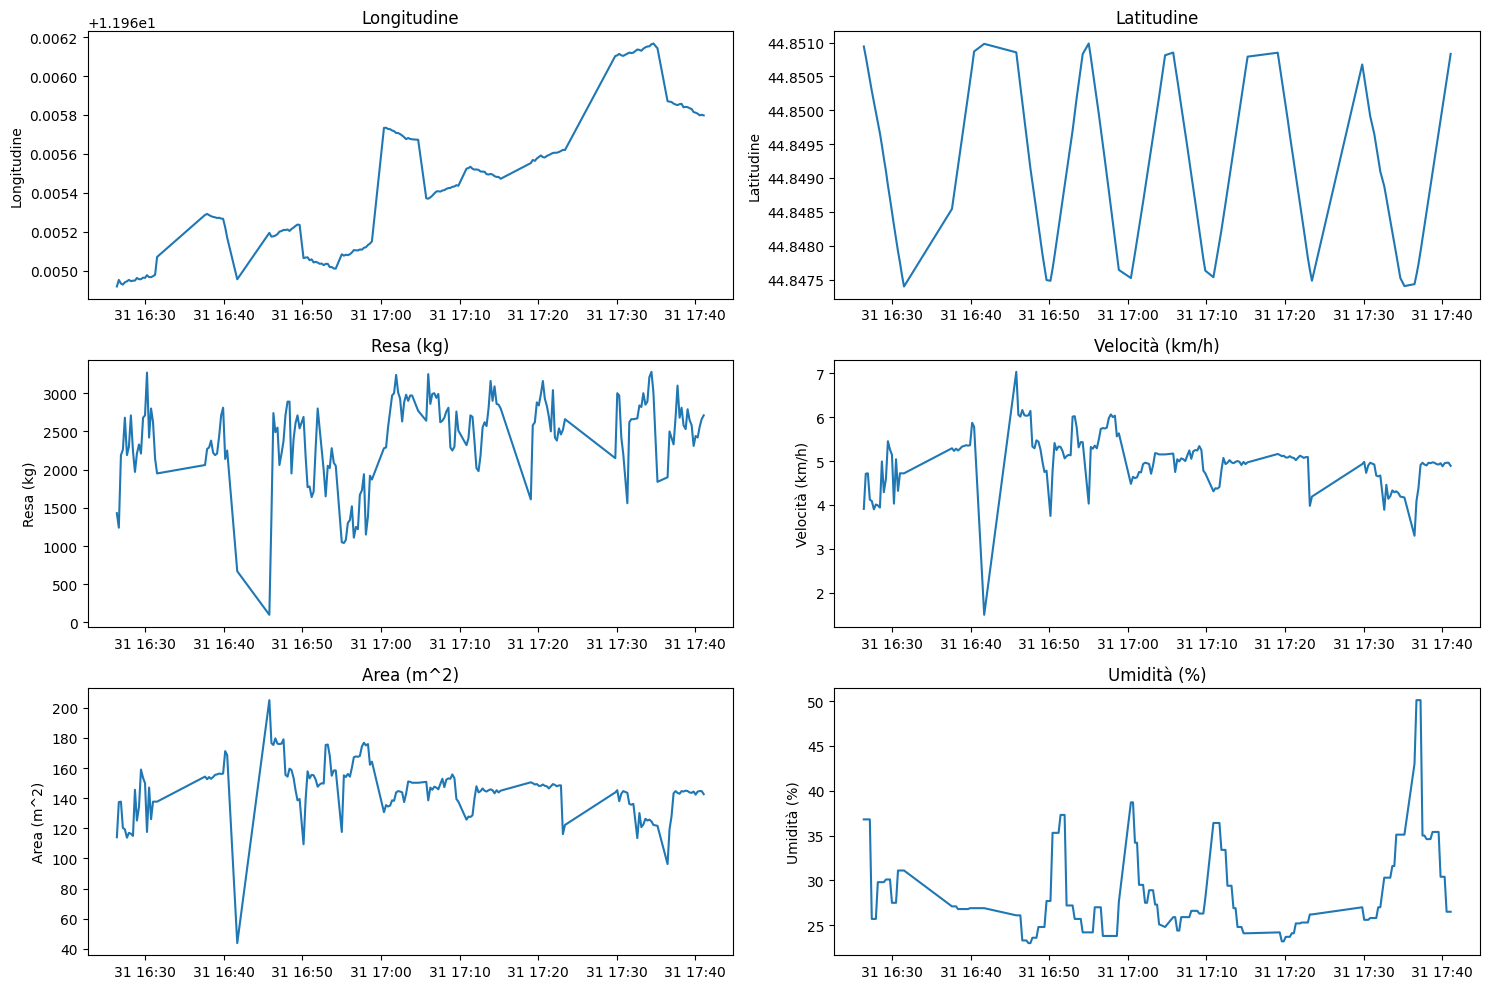

In [44]:
# Creo figura e assi per i subplot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Plot delle varie colonne rispetto alla colonna 'Data/Ora'
axs[0, 0].plot(dati0['Data/Ora'], dati0['Longitudine'])
axs[0, 0].set_title('Longitudine')
axs[0, 0].set_ylabel('Longitudine')

axs[0, 1].plot(dati0['Data/Ora'], dati0['Latitudine'])
axs[0, 1].set_title('Latitudine')
axs[0, 1].set_ylabel('Latitudine')

axs[1, 0].plot(dati0['Data/Ora'], dati0['Resa (kg)'])
axs[1, 0].set_title('Resa (kg)')
axs[1, 0].set_ylabel('Resa (kg)')

axs[1, 1].plot(dati0['Data/Ora'], dati0['Velocità (km/h)'])
axs[1, 1].set_title('Velocità (km/h)')
axs[1, 1].set_ylabel('Velocità (km/h)')

axs[2, 0].plot(dati0['Data/Ora'], dati0['Area (m^2)'])
axs[2, 0].set_title('Area (m^2)')
axs[2, 0].set_ylabel('Area (m^2)')

axs[2, 1].plot(dati0['Data/Ora'], dati0['Umidità (%)'])
axs[2, 1].set_title('Umidità (%)')
axs[2, 1].set_ylabel('Umidità (%)')

# Aggiusto la disposizione e lo spaziamento dei subplot
plt.tight_layout()

# Mostro il plot
plt.show()

##### Gruppo 2 (03/09/2022)

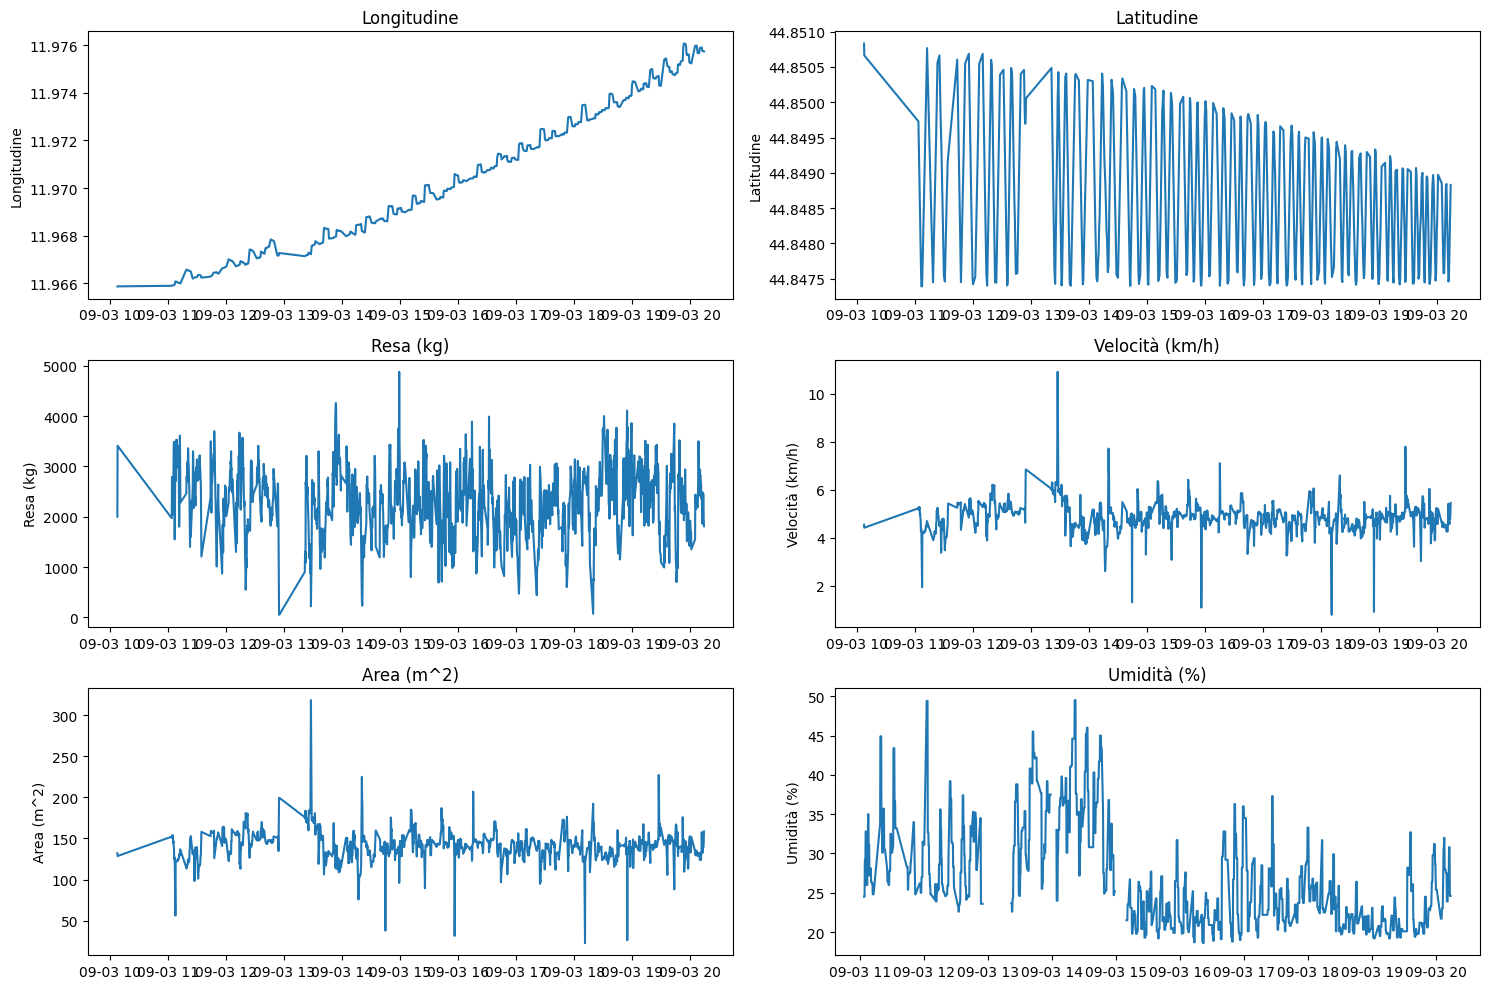

In [45]:
# Creo figura e assi per i subplot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Plot delle varie colonne rispetto alla colonna 'Data/Ora'
axs[0, 0].plot(dati1['Data/Ora'], dati1['Longitudine'])
axs[0, 0].set_title('Longitudine')
axs[0, 0].set_ylabel('Longitudine')

axs[0, 1].plot(dati1['Data/Ora'], dati1['Latitudine'])
axs[0, 1].set_title('Latitudine')
axs[0, 1].set_ylabel('Latitudine')

axs[1, 0].plot(dati1['Data/Ora'], dati1['Resa (kg)'])
axs[1, 0].set_title('Resa (kg)')
axs[1, 0].set_ylabel('Resa (kg)')

axs[1, 1].plot(dati1['Data/Ora'], dati1['Velocità (km/h)'])
axs[1, 1].set_title('Velocità (km/h)')
axs[1, 1].set_ylabel('Velocità (km/h)')

axs[2, 0].plot(dati1['Data/Ora'], dati1['Area (m^2)'])
axs[2, 0].set_title('Area (m^2)')
axs[2, 0].set_ylabel('Area (m^2)')

axs[2, 1].plot(dati1['Data/Ora'], dati1['Umidità (%)'])
axs[2, 1].set_title('Umidità (%)')
axs[2, 1].set_ylabel('Umidità (%)')

# Aggiusto la disposizione e lo spaziamento dei subplot
plt.tight_layout()

# Mostro il plot
plt.show()

##### Gruppo 3 (05/09/2022)

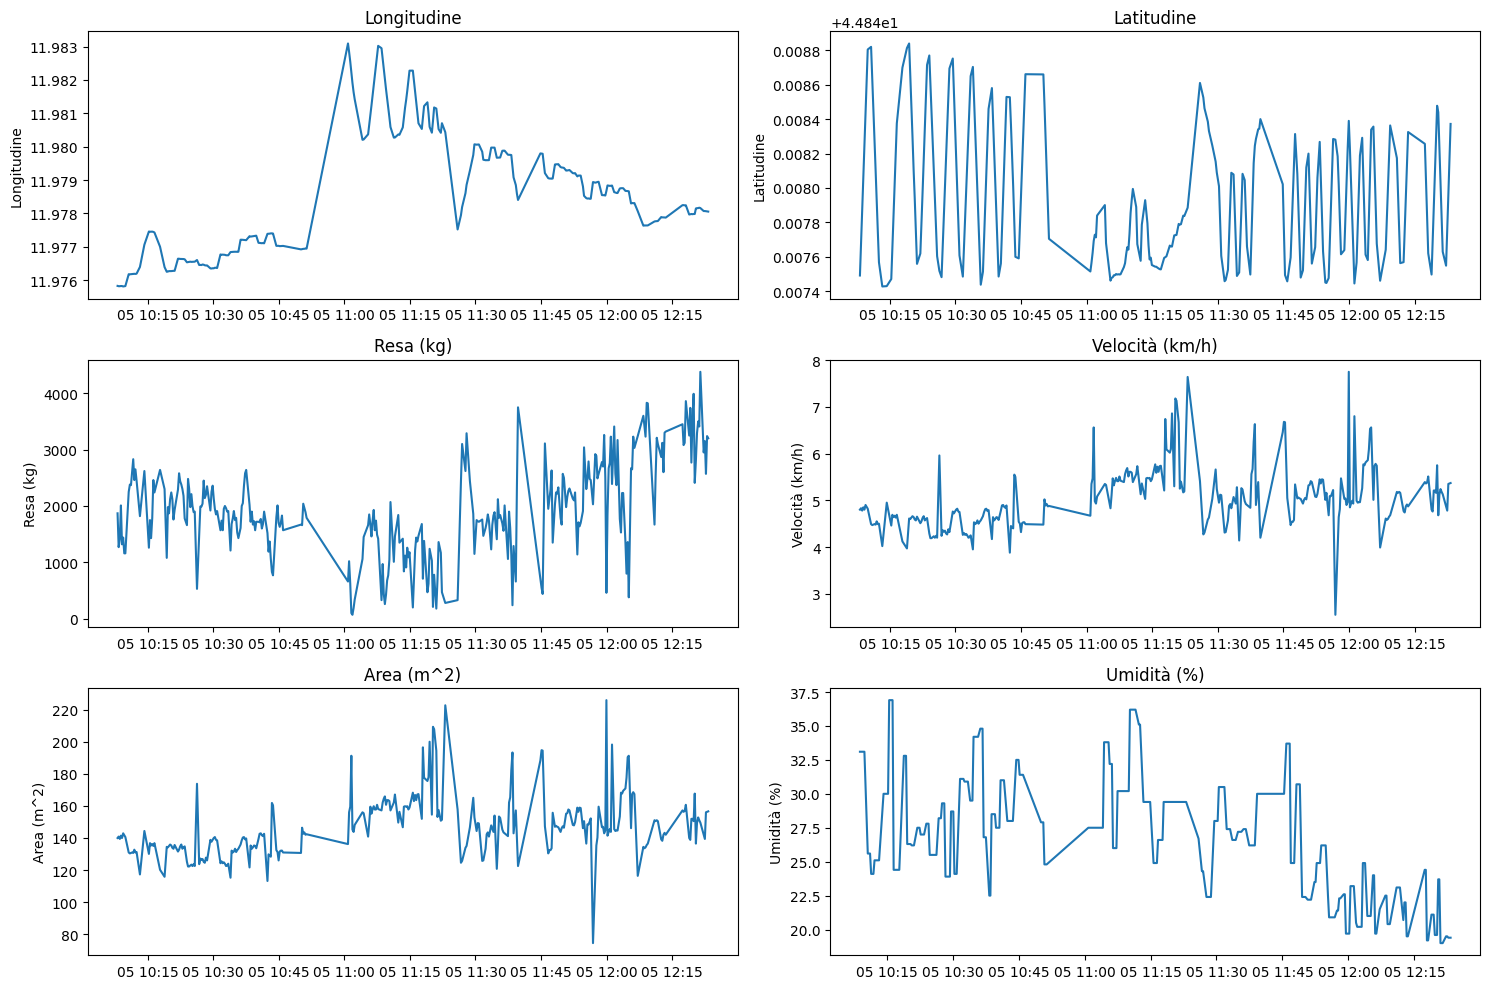

In [46]:
# Creo figura e assi per i subplot
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Plot delle varie colonne rispetto alla colonna 'Data/Ora'
axs[0, 0].plot(dati2['Data/Ora'], dati2['Longitudine'])
axs[0, 0].set_title('Longitudine')
axs[0, 0].set_ylabel('Longitudine')

axs[0, 1].plot(dati2['Data/Ora'], dati2['Latitudine'])
axs[0, 1].set_title('Latitudine')
axs[0, 1].set_ylabel('Latitudine')

axs[1, 0].plot(dati2['Data/Ora'], dati2['Resa (kg)'])
axs[1, 0].set_title('Resa (kg)')
axs[1, 0].set_ylabel('Resa (kg)')

axs[1, 1].plot(dati2['Data/Ora'], dati2['Velocità (km/h)'])
axs[1, 1].set_title('Velocità (km/h)')
axs[1, 1].set_ylabel('Velocità (km/h)')

axs[2, 0].plot(dati2['Data/Ora'], dati2['Area (m^2)'])
axs[2, 0].set_title('Area (m^2)')
axs[2, 0].set_ylabel('Area (m^2)')

axs[2, 1].plot(dati2['Data/Ora'], dati2['Umidità (%)'])
axs[2, 1].set_title('Umidità (%)')
axs[2, 1].set_ylabel('Umidità (%)')

# Aggiusto la disposizione e lo spaziamento dei subplot
plt.tight_layout()

# Mostro il plot
plt.show()

#### Grafico del percorso della macchina agricola con corrispondente resa

##### Gruppo 1 (31/08/2022)

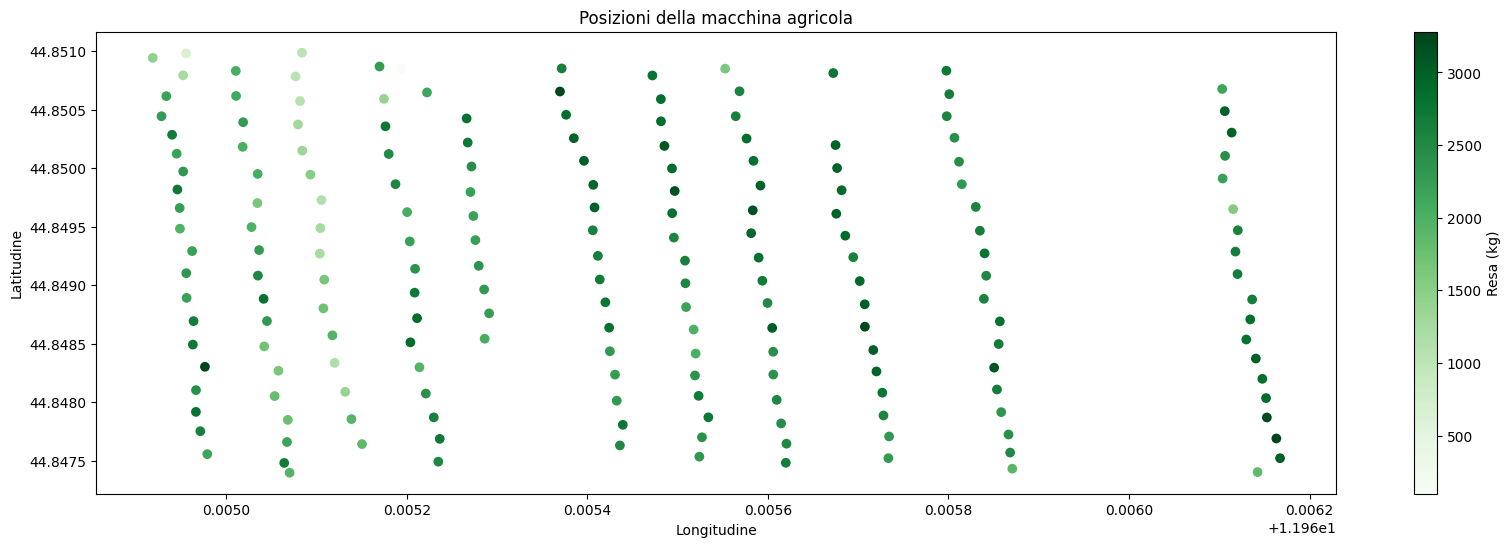

In [47]:
longitudine = dati0['Longitudine']
latitudine = dati0['Latitudine']
resa = dati0['Resa (kg)']

plt.figure(figsize=(20, 6))
plt.scatter(longitudine, latitudine, c=resa, cmap='Greens')
plt.colorbar(label='Resa (kg)')
plt.title('Posizioni della macchina agricola')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show()

##### Gruppo 2 (03/09/2022)

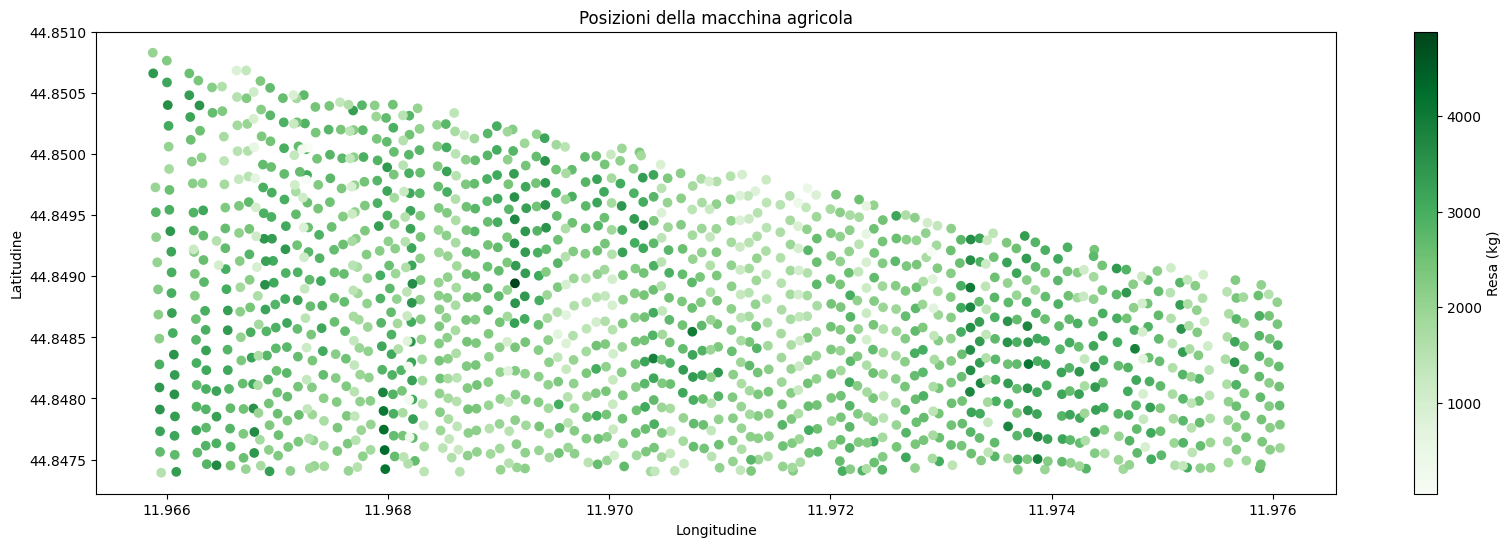

In [48]:
longitudine = dati1['Longitudine']
latitudine = dati1['Latitudine']
resa = dati1['Resa (kg)']

plt.figure(figsize=(20, 6))
plt.scatter(longitudine, latitudine, c=resa, cmap='Greens')
plt.colorbar(label='Resa (kg)')
plt.title('Posizioni della macchina agricola')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show()

##### Gruppo 3 (05/09/2022)

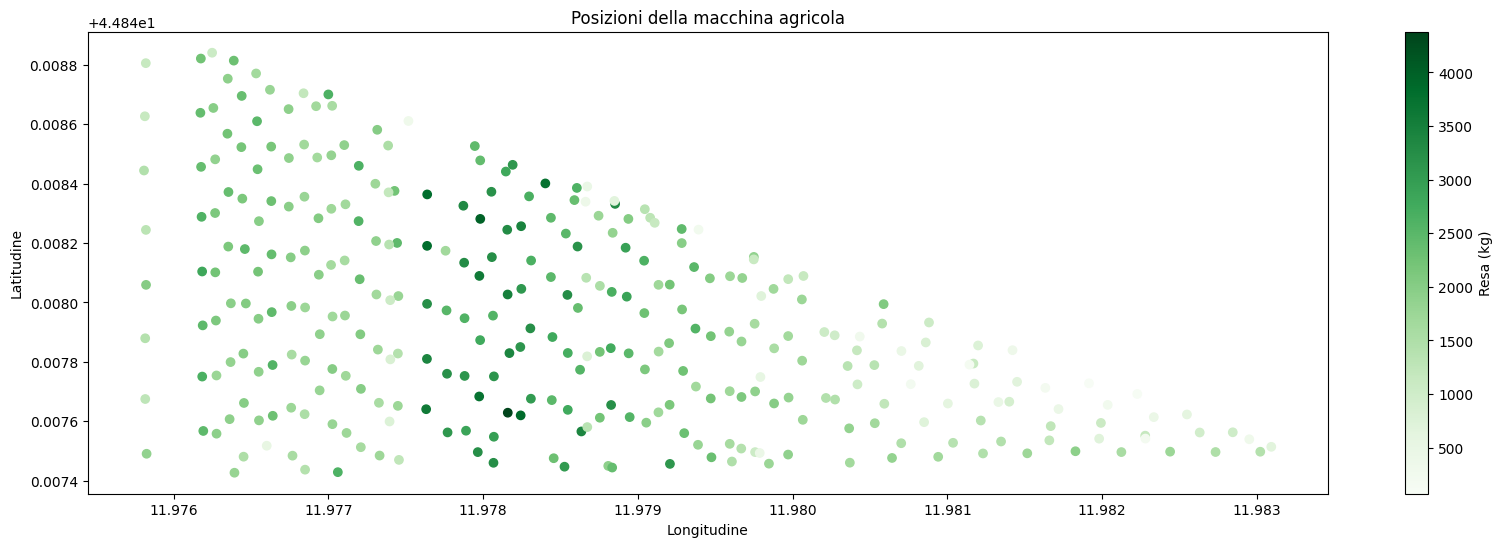

In [49]:
longitudine = dati2['Longitudine']
latitudine = dati2['Latitudine']
resa = dati2['Resa (kg)']

plt.figure(figsize=(20, 6))
plt.scatter(longitudine, latitudine, c=resa, cmap='Greens')
plt.colorbar(label='Resa (kg)')
plt.title('Posizioni della macchina agricola')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show()

##### Dataset totale

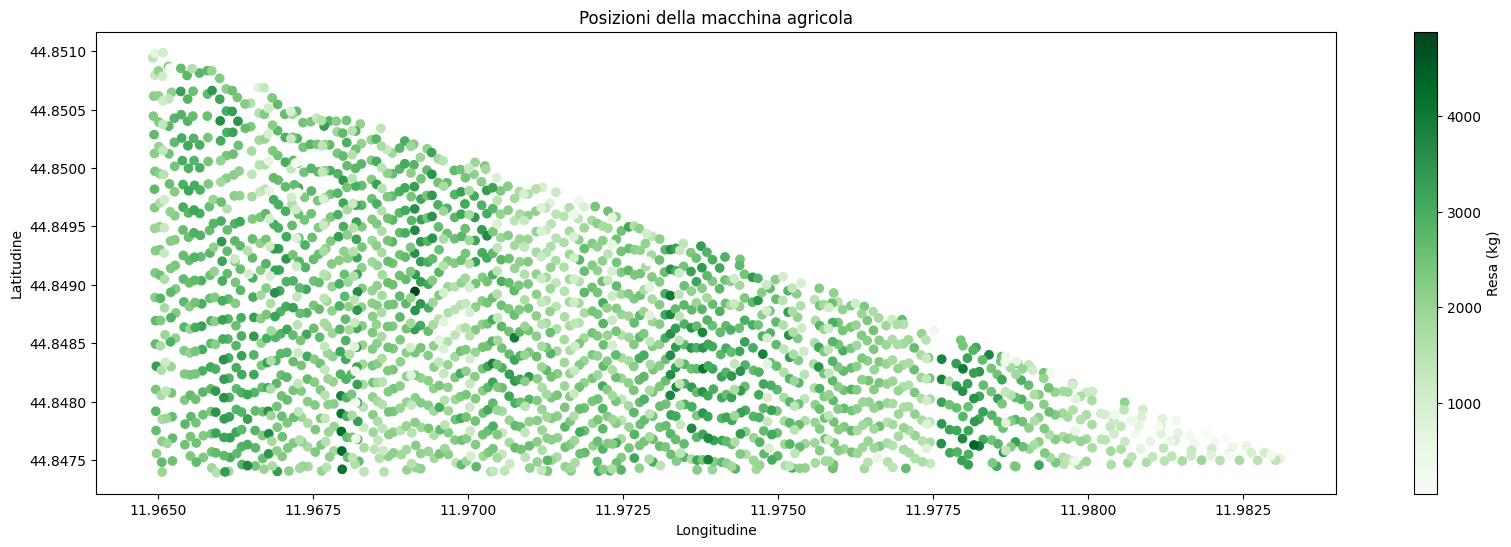

In [50]:
longitudine = dati['Longitudine']
latitudine = dati['Latitudine']
resa = dati['Resa (kg)']

plt.figure(figsize=(20, 6))
plt.scatter(longitudine, latitudine, c=resa, cmap='Greens')
plt.colorbar(label='Resa (kg)')
plt.title('Posizioni della macchina agricola')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show()

### Interpolazione spaziale dei dati (per dedurre la resa in una griglia di punti più fitta di quella originale)

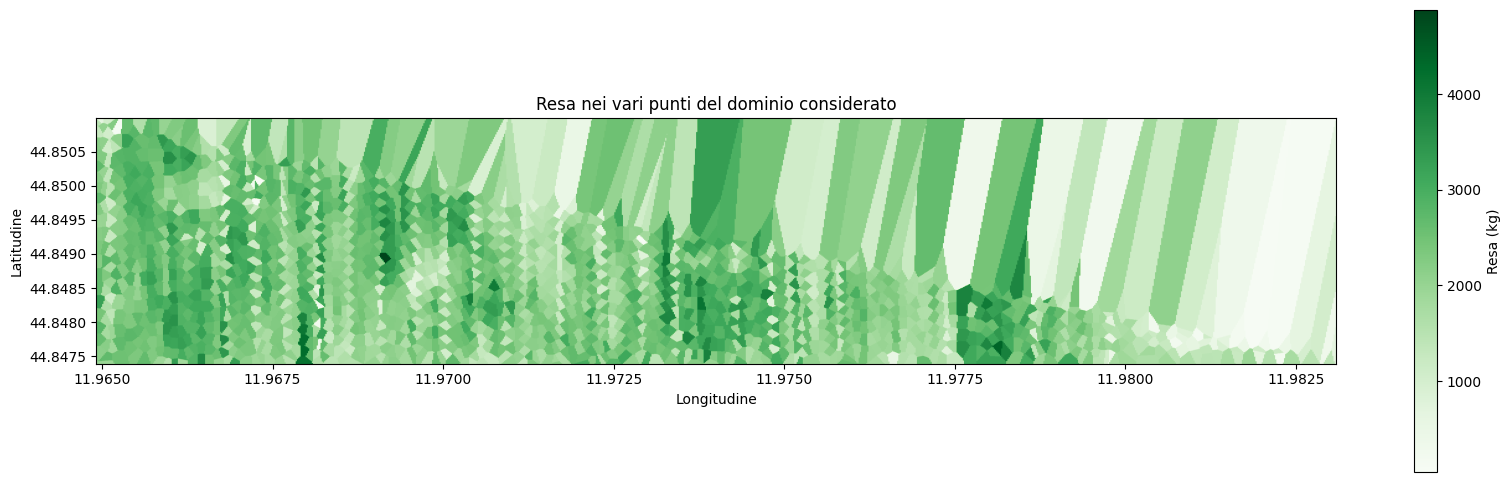

In [51]:
# Creo una griglia regolare di longitudini e latitudini
long_grid, lat_grid = np.mgrid[min(longitudine):max(longitudine):1000j, min(latitudine):max(latitudine):1000j] # In questo caso la griglia è 1000 punti x 1000 punti

# Uso griddata per interpolare i valori di resa
resa_grid = griddata((dati['Longitudine'], dati['Latitudine']), dati['Resa (kg)'], (long_grid, lat_grid), method='nearest') # Per sapere la resa dei nuovi punti, grazie al metodo nearest, viene preso il valore (e di conseguenza il colore) del punto più vicino già presente nei dati

# Creo la heatmap
plt.figure(figsize=(20, 6))
plt.imshow(resa_grid.T, extent=(min(dati['Longitudine']), max(dati['Longitudine']), min(dati['Latitudine']), max(dati['Latitudine'])), origin='lower', cmap='Greens')
plt.colorbar(label='Resa (kg)')
plt.title('Resa nei vari punti del dominio considerato')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show()

### Accedo ai valori dell'indice vegetativo NDVI tramite AppEEARS (https://appeears.earthdatacloud.nasa.gov/task/point)

#### Esporto i dati che mi servono in un file csv da caricare sul sito (accetta massimo 1000 righe per volta, quindi ne esporto 2 in questo caso)

In [52]:
df_export = pd.DataFrame({
    'ID': range(1, len(dati[:1000]) + 1),
    'Category': '',
    'Latitude': dati['Latitudine'][:1000],
    'Longitude': dati['Longitudine'][:1000]
})

# df_export.to_csv('File da caricare su AppEEARS (primi 1000).csv', index=False)

df_export2 = pd.DataFrame({
    'ID': range(1001, len(dati[1000:]) + 1001),
    'Category': '',
    'Latitude': dati['Latitudine'][1000:],
    'Longitude': dati['Longitudine'][1000:]
})

# df_export2.to_csv('File da caricare su AppEEARS (dati rimanenti).csv', index=False)

#### Leggo i risultati scaricati da quel sito (periodo richiesto: 31/08/2021 - 30/08/2022; frequenza campionamento: 16 giorni; risoluzione: 250 m)

In [53]:
ris1 = pd.read_csv('Risultati1.csv')
ris2 = pd.read_csv('Risultati2.csv')

ris = pd.concat([ris1, ris2], axis=0)
ris

Category    ID   Latitude  Longitude        Date MODIS_Tile  \
0           NaN     1  44.850943  11.964918  2021-08-29     h18v04   
1           NaN     1  44.850943  11.964918  2021-09-14     h18v04   
2           NaN     1  44.850943  11.964918  2021-09-30     h18v04   
3           NaN     1  44.850943  11.964918  2021-10-16     h18v04   
4           NaN     1  44.850943  11.964918  2021-11-01     h18v04   
...         ...   ...        ...        ...         ...        ...   
23083       NaN  1962  44.848373  11.978053  2022-06-26     h18v04   
23084       NaN  1962  44.848373  11.978053  2022-07-12     h18v04   
23085       NaN  1962  44.848373  11.978053  2022-07-28     h18v04   
23086       NaN  1962  44.848373  11.978053  2022-08-13     h18v04   
23087       NaN  1962  44.848373  11.978053  2022-08-29     h18v04   

       MOD13Q1_061_Line_Y_250m  MOD13Q1_061_Sample_X_250m  \
0                       2471.0                     4071.0   
1                       2471.0                     4071.0   
2                       2471.0                     4071.0   
3                       2471.0                     4071.0   
4                       2471.0                     4071.0   
...                        ...                        ...   
23083                   2472.0                     4076.0   
23084                   2472.0                     4076.0   
23085                   2472.0                     4076.0   
23086                   2472.0                     4076.0   
23087                   2472.0                     4076.0   

       MOD13Q1_061__250m_16_days_NDVI  MOD13Q1_061__250m_16_days_VI_Quality  \
0                              0.5608                                2116.0   
1                              0.4990                                2116.0   
2                              0.5077                                2116.0   
3                              0.4161                                2116.0   
4                              0.2883                                2120.0   
...                               ...                                   ...   
23083                          0.6317                                2116.0   
23084                          0.6439                                2116.0   
23085                          0.5327                                2116.0   
23086                          0.3602                                2116.0   
23087                          0.3541                                2120.0   

       ... MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction  \
0      ...                                                0b0                
1      ...                                                0b0                
2      ...                                                0b0                
3      ...                                                0b0                
4      ...                                                0b0                
...    ...                                                ...                
23083  ...                                                0b0                
23084  ...                                                0b0                
23085  ...                                                0b0                
23086  ...                                                0b0                
23087  ...                                                0b0                

      MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction_Description  \
0                                                     No                            
1                                                     No                            
2                                                     No                            
3                                                     No                            
4                                                     No                            
...                                  

In [54]:
ris1

Category   ID   Latitude  Longitude        Date MODIS_Tile  \
0           NaN    1  44.850943  11.964918  2021-08-29     h18v04   
1           NaN    1  44.850943  11.964918  2021-09-14     h18v04   
2           NaN    1  44.850943  11.964918  2021-09-30     h18v04   
3           NaN    1  44.850943  11.964918  2021-10-16     h18v04   
4           NaN    1  44.850943  11.964918  2021-11-01     h18v04   
...         ...  ...        ...        ...         ...        ...   
23995       NaN  999  44.847467  11.970675  2022-06-26     h18v04   
23996       NaN  999  44.847467  11.970675  2022-07-12     h18v04   
23997       NaN  999  44.847467  11.970675  2022-07-28     h18v04   
23998       NaN  999  44.847467  11.970675  2022-08-13     h18v04   
23999       NaN  999  44.847467  11.970675  2022-08-29     h18v04   

       MOD13Q1_061_Line_Y_250m  MOD13Q1_061_Sample_X_250m  \
0                       2471.0                     4071.0   
1                       2471.0                     4071.0   
2                       2471.0                     4071.0   
3                       2471.0                     4071.0   
4                       2471.0                     4071.0   
...                        ...                        ...   
23995                   2473.0                     4073.0   
23996                   2473.0                     4073.0   
23997                   2473.0                     4073.0   
23998                   2473.0                     4073.0   
23999                   2473.0                     4073.0   

       MOD13Q1_061__250m_16_days_NDVI  MOD13Q1_061__250m_16_days_VI_Quality  \
0                              0.5608                                2116.0   
1                              0.4990                                2116.0   
2                              0.5077                                2116.0   
3                              0.4161                                2116.0   
4                              0.2883                                2120.0   
...                               ...                                   ...   
23995                          0.7636                                2116.0   
23996                          0.6886                                2116.0   
23997                          0.4147                                2116.0   
23998                          0.3026                                2116.0   
23999                          0.2487                                2116.0   

       ... MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction  \
0      ...                                                0b0                
1      ...                                                0b0                
2      ...                                                0b0                
3      ...                                                0b0                
4      ...                                                0b0                
...    ...                                                ...                
23995  ...                                                0b0                
23996  ...                                                0b0                
23997  ...                                                0b0                
23998  ...                                                0b0                
23999  ...                                                0b0                

      MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction_Description  \
0                                                     No                            
1                                                     No                            
2                                                     No                            
3                                                     No                            
4                                                     No                            
...                                              

In [55]:
ris2

Category    ID   Latitude  Longitude        Date MODIS_Tile  \
0           NaN  1001  44.847841  11.970669  2021-08-29     h18v04   
1           NaN  1001  44.847841  11.970669  2021-09-14     h18v04   
2           NaN  1001  44.847841  11.970669  2021-09-30     h18v04   
3           NaN  1001  44.847841  11.970669  2021-10-16     h18v04   
4           NaN  1001  44.847841  11.970669  2021-11-01     h18v04   
...         ...   ...        ...        ...         ...        ...   
23083       NaN  1962  44.848373  11.978053  2022-06-26     h18v04   
23084       NaN  1962  44.848373  11.978053  2022-07-12     h18v04   
23085       NaN  1962  44.848373  11.978053  2022-07-28     h18v04   
23086       NaN  1962  44.848373  11.978053  2022-08-13     h18v04   
23087       NaN  1962  44.848373  11.978053  2022-08-29     h18v04   

       MOD13Q1_061_Line_Y_250m  MOD13Q1_061_Sample_X_250m  \
0                       2473.0                     4073.0   
1                       2473.0                     4073.0   
2                       2473.0                     4073.0   
3                       2473.0                     4073.0   
4                       2473.0                     4073.0   
...                        ...                        ...   
23083                   2472.0                     4076.0   
23084                   2472.0                     4076.0   
23085                   2472.0                     4076.0   
23086                   2472.0                     4076.0   
23087                   2472.0                     4076.0   

       MOD13Q1_061__250m_16_days_NDVI  MOD13Q1_061__250m_16_days_VI_Quality  \
0                              0.8357                                2116.0   
1                              0.3335                                2116.0   
2                              0.1768                                2116.0   
3                              0.2245                                2116.0   
4                              0.1418                                2120.0   
...                               ...                                   ...   
23083                          0.6317                                2116.0   
23084                          0.6439                                2116.0   
23085                          0.5327                                2116.0   
23086                          0.3602                                2116.0   
23087                          0.3541                                2120.0   

       ... MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction  \
0      ...                                                0b0                
1      ...                                                0b0                
2      ...                                                0b0                
3      ...                                                0b0                
4      ...                                                0b0                
...    ...                                                ...                
23083  ...                                                0b0                
23084  ...                                                0b0                
23085  ...                                                0b0                
23086  ...                                                0b0                
23087  ...                                                0b0                

      MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction_Description  \
0                                                     No                            
1                                                     No                            
2                                                     No                            
3                                                     No                            
4                                                     No                            
...                                  

In [56]:
ris

Category    ID   Latitude  Longitude        Date MODIS_Tile  \
0           NaN     1  44.850943  11.964918  2021-08-29     h18v04   
1           NaN     1  44.850943  11.964918  2021-09-14     h18v04   
2           NaN     1  44.850943  11.964918  2021-09-30     h18v04   
3           NaN     1  44.850943  11.964918  2021-10-16     h18v04   
4           NaN     1  44.850943  11.964918  2021-11-01     h18v04   
...         ...   ...        ...        ...         ...        ...   
23083       NaN  1962  44.848373  11.978053  2022-06-26     h18v04   
23084       NaN  1962  44.848373  11.978053  2022-07-12     h18v04   
23085       NaN  1962  44.848373  11.978053  2022-07-28     h18v04   
23086       NaN  1962  44.848373  11.978053  2022-08-13     h18v04   
23087       NaN  1962  44.848373  11.978053  2022-08-29     h18v04   

       MOD13Q1_061_Line_Y_250m  MOD13Q1_061_Sample_X_250m  \
0                       2471.0                     4071.0   
1                       2471.0                     4071.0   
2                       2471.0                     4071.0   
3                       2471.0                     4071.0   
4                       2471.0                     4071.0   
...                        ...                        ...   
23083                   2472.0                     4076.0   
23084                   2472.0                     4076.0   
23085                   2472.0                     4076.0   
23086                   2472.0                     4076.0   
23087                   2472.0                     4076.0   

       MOD13Q1_061__250m_16_days_NDVI  MOD13Q1_061__250m_16_days_VI_Quality  \
0                              0.5608                                2116.0   
1                              0.4990                                2116.0   
2                              0.5077                                2116.0   
3                              0.4161                                2116.0   
4                              0.2883                                2120.0   
...                               ...                                   ...   
23083                          0.6317                                2116.0   
23084                          0.6439                                2116.0   
23085                          0.5327                                2116.0   
23086                          0.3602                                2116.0   
23087                          0.3541                                2120.0   

       ... MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction  \
0      ...                                                0b0                
1      ...                                                0b0                
2      ...                                                0b0                
3      ...                                                0b0                
4      ...                                                0b0                
...    ...                                                ...                
23083  ...                                                0b0                
23084  ...                                                0b0                
23085  ...                                                0b0                
23086  ...                                                0b0                
23087  ...                                                0b0                

      MOD13Q1_061__250m_16_days_VI_Quality_Atmosphere_BRDF_Correction_Description  \
0                                                     No                            
1                                                     No                            
2                                                     No                            
3                                                     No                            
4                                                     No                            
...                                  

#### Filtro solo in base alle colonne che mi interessano

In [57]:
ris_utile = ris[['ID', 'Latitude', 'Longitude', 'Date', 'MOD13Q1_061__250m_16_days_NDVI']]
ris_utile

ID   Latitude  Longitude        Date  MOD13Q1_061__250m_16_days_NDVI
0         1  44.850943  11.964918  2021-08-29                          0.5608
1         1  44.850943  11.964918  2021-09-14                          0.4990
2         1  44.850943  11.964918  2021-09-30                          0.5077
3         1  44.850943  11.964918  2021-10-16                          0.4161
4         1  44.850943  11.964918  2021-11-01                          0.2883
...     ...        ...        ...         ...                             ...
23083  1962  44.848373  11.978053  2022-06-26                          0.6317
23084  1962  44.848373  11.978053  2022-07-12                          0.6439
23085  1962  44.848373  11.978053  2022-07-28                          0.5327
23086  1962  44.848373  11.978053  2022-08-13                          0.3602
23087  1962  44.848373  11.978053  2022-08-29                          0.3541

[47088 rows x 5 columns]

#### Raggruppo i dati in base al valore medio del NDVI

In [58]:
ris_raggruppato = ris_utile.groupby(['ID', 'Latitude', 'Longitude']).agg({'MOD13Q1_061__250m_16_days_NDVI': 'mean'}).rename(columns = {'MOD13Q1_061__250m_16_days_NDVI': 'NDVI medio'})
ris_raggruppato

NDVI medio
ID   Latitude  Longitude            
1    44.850943 11.964918    0.377750
2    44.850793 11.964952    0.377750
3    44.850615 11.964934    0.377750
4    44.850444 11.964928    0.377750
5    44.850285 11.964940    0.377750
...                              ...
1958 44.847548 11.978069    0.329029
1959 44.847751 11.978069    0.329029
1960 44.847956 11.978063    0.295067
1961 44.848153 11.978056    0.295067
1962 44.848373 11.978053    0.295067

[1962 rows x 1 columns]

In [59]:
ris_raggruppato = ris_raggruppato.reset_index()
ris_raggruppato

ID   Latitude  Longitude  NDVI medio
0        1  44.850943  11.964918    0.377750
1        2  44.850793  11.964952    0.377750
2        3  44.850615  11.964934    0.377750
3        4  44.850444  11.964928    0.377750
4        5  44.850285  11.964940    0.377750
...    ...        ...        ...         ...
1957  1958  44.847548  11.978069    0.329029
1958  1959  44.847751  11.978069    0.329029
1959  1960  44.847956  11.978063    0.295067
1960  1961  44.848153  11.978056    0.295067
1961  1962  44.848373  11.978053    0.295067

[1962 rows x 4 columns]

In [60]:
ris_raggruppato = ris_raggruppato[['ID', 'Latitude', 'Longitude', 'NDVI medio']]
ris_raggruppato

ID   Latitude  Longitude  NDVI medio
0        1  44.850943  11.964918    0.377750
1        2  44.850793  11.964952    0.377750
2        3  44.850615  11.964934    0.377750
3        4  44.850444  11.964928    0.377750
4        5  44.850285  11.964940    0.377750
...    ...        ...        ...         ...
1957  1958  44.847548  11.978069    0.329029
1958  1959  44.847751  11.978069    0.329029
1959  1960  44.847956  11.978063    0.295067
1960  1961  44.848153  11.978056    0.295067
1961  1962  44.848373  11.978053    0.295067

[1962 rows x 4 columns]

In [61]:
ris_raggruppato = ris_raggruppato.rename(columns = {'Latitude': 'Latitudine', 'Longitude': 'Longitudine'})
ris_raggruppato

ID  Latitudine  Longitudine  NDVI medio
0        1   44.850943    11.964918    0.377750
1        2   44.850793    11.964952    0.377750
2        3   44.850615    11.964934    0.377750
3        4   44.850444    11.964928    0.377750
4        5   44.850285    11.964940    0.377750
...    ...         ...          ...         ...
1957  1958   44.847548    11.978069    0.329029
1958  1959   44.847751    11.978069    0.329029
1959  1960   44.847956    11.978063    0.295067
1960  1961   44.848153    11.978056    0.295067
1961  1962   44.848373    11.978053    0.295067

[1962 rows x 4 columns]

In [62]:
# Guardo per curiosità quanti valori unici di "NDVI medio" ci sono nel dataset raggruppato
ris_raggruppato['NDVI medio'].value_counts()

0.331646    340
0.310429    340
0.307787    274
0.303962    172
0.344283     98
0.310558     96
0.308729     93
0.306737     91
0.373246     84
0.379083     83
0.329029     79
0.295067     75
0.351058     56
0.377750     51
0.379600     14
0.359046     12
0.285838      3
0.371262      1
Name: NDVI medio, dtype: int64

### Aggiungo la nuova colonna ai dati originali (associando ogni valore del NDVI medio alla corrispondente coppia longitudine-latitudine)

In [63]:
dati

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0    2022-08-31 16:26:24    11.964918   44.850943     1430.0             3.91   
1    2022-08-31 16:26:39    11.964952   44.850793     1240.0             4.71   
2    2022-08-31 16:26:55    11.964934   44.850615     2190.0             4.72   
3    2022-08-31 16:27:10    11.964928   44.850444     2260.0             4.12   
4    2022-08-31 16:27:25    11.964940   44.850285     2680.0             4.09   
...                  ...          ...         ...        ...              ...   
1957 2022-09-05 12:22:12    11.978069   44.847548     2950.0             4.87   
1958 2022-09-05 12:22:28    11.978069   44.847751     3150.0             4.78   
1959 2022-09-05 12:22:43    11.978063   44.847956     2570.0             5.35   
1960 2022-09-05 12:22:58    11.978056   44.848153     3240.0             5.36   
1961 2022-09-05 12:23:14    11.978053   44.848373     3200.0             5.37   

      Area (m^2)  Umidità (%)                         Geometry  
0        114.042         36.8  POINT (1331928.635 5598085.894)  
1        137.375         36.8  POINT (1331932.375 5598062.435)  
2        137.667         36.8  POINT (1331930.305 5598034.501)  
3        120.167         36.8  POINT (1331929.715 5598007.541)  
4        119.292         25.7  POINT (1331931.017 5597982.716)  
...          ...          ...                              ...  
1957     142.042         19.5  POINT (1333392.520 5597552.900)  
1958     139.417         19.5  POINT (1333392.564 5597584.805)  
1959     156.042         19.4  POINT (1333391.896 5597616.898)  
1960     156.333         19.4  POINT (1333391.106 5597647.814)  
1961     156.625         19.4  POINT (1333390.761 5597682.358)  

[1962 rows x 8 columns]

In [64]:
dati_finali = pd.merge(dati, ris_raggruppato[['Longitudine', 'Latitudine', 'NDVI medio']], on=['Longitudine', 'Latitudine'], how='left')
dati_finali

Data/Ora  Longitudine  Latitudine  Resa (kg)  Velocità (km/h)  \
0    2022-08-31 16:26:24    11.964918   44.850943     1430.0             3.91   
1    2022-08-31 16:26:39    11.964952   44.850793     1240.0             4.71   
2    2022-08-31 16:26:55    11.964934   44.850615     2190.0             4.72   
3    2022-08-31 16:27:10    11.964928   44.850444     2260.0             4.12   
4    2022-08-31 16:27:25    11.964940   44.850285     2680.0             4.09   
...                  ...          ...         ...        ...              ...   
1957 2022-09-05 12:22:12    11.978069   44.847548     2950.0             4.87   
1958 2022-09-05 12:22:28    11.978069   44.847751     3150.0             4.78   
1959 2022-09-05 12:22:43    11.978063   44.847956     2570.0             5.35   
1960 2022-09-05 12:22:58    11.978056   44.848153     3240.0             5.36   
1961 2022-09-05 12:23:14    11.978053   44.848373     3200.0             5.37   

      Area (m^2)  Umidità (%)                         Geometry  NDVI medio  
0        114.042         36.8  POINT (1331928.635 5598085.894)    0.377750  
1        137.375         36.8  POINT (1331932.375 5598062.435)    0.377750  
2        137.667         36.8  POINT (1331930.305 5598034.501)    0.377750  
3        120.167         36.8  POINT (1331929.715 5598007.541)    0.377750  
4        119.292         25.7  POINT (1331931.017 5597982.716)    0.377750  
...          ...          ...                              ...         ...  
1957     142.042         19.5  POINT (1333392.520 5597552.900)    0.329029  
1958     139.417         19.5  POINT (1333392.564 5597584.805)    0.329029  
1959     156.042         19.4  POINT (1333391.896 5597616.898)    0.295067  
1960     156.333         19.4  POINT (1333391.106 5597647.814)    0.295067  
1961     156.625         19.4  POINT (1333390.761 5597682.358)    0.295067  

[1962 rows x 9 columns]

### Guardo se c'è correlazione lineare (correlazione di Pearson) tra i dati (in particolare mi interessa tra NDVI medio e resa)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_16956\1364667591.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dati_finali.corr()


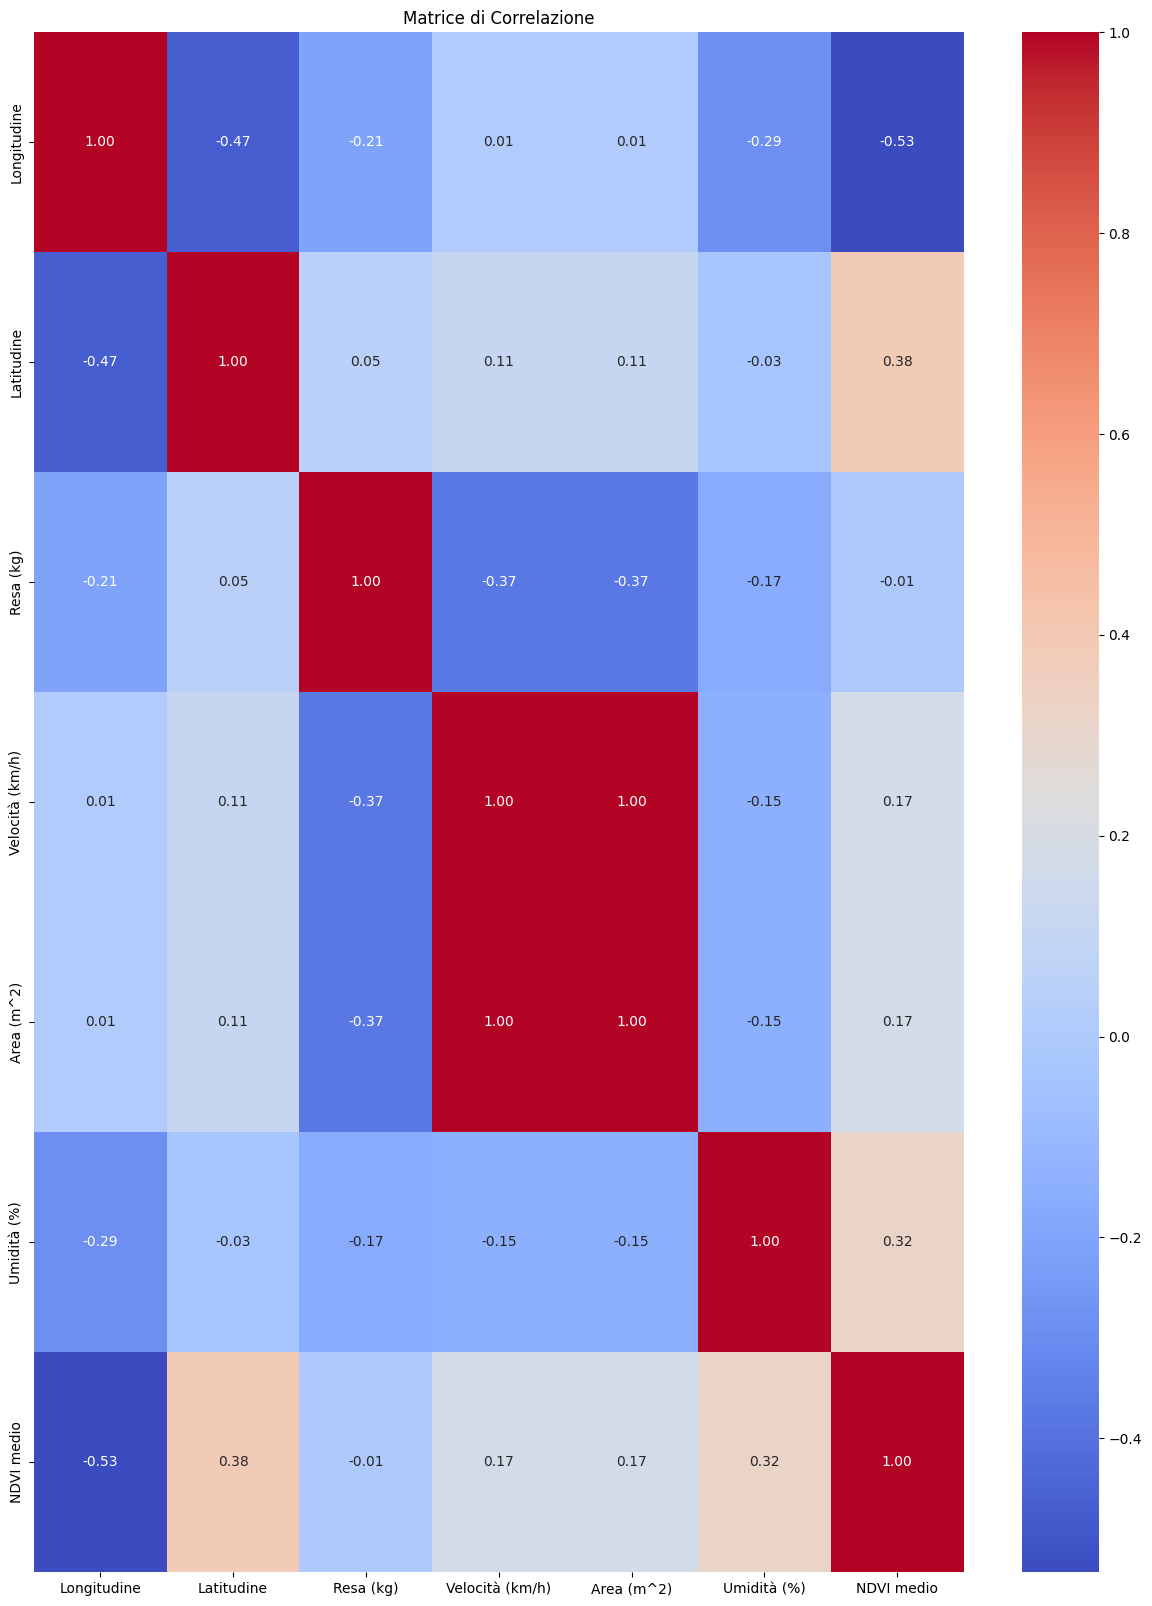

In [65]:
correlation_matrix = dati_finali.corr()

plt.figure(figsize=(15, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

# Posso concludere che non c'è correlazione lineare tra NDVI e resa (correlazione di -0.01)

### Cerco un'eventuale relazione non lineare tra la resa e le variabili NDVI medio, longitudine e latitudine usando una random forest

#### Tengo solo le variabili che mi interessano

In [66]:
df_short_list = dati_finali.copy()
df_short_list = df_short_list[['NDVI medio', 'Longitudine' , 'Latitudine', 'Resa (kg)']]
df_short_list

NDVI medio  Longitudine  Latitudine  Resa (kg)
0       0.377750    11.964918   44.850943     1430.0
1       0.377750    11.964952   44.850793     1240.0
2       0.377750    11.964934   44.850615     2190.0
3       0.377750    11.964928   44.850444     2260.0
4       0.377750    11.964940   44.850285     2680.0
...          ...          ...         ...        ...
1957    0.329029    11.978069   44.847548     2950.0
1958    0.329029    11.978069   44.847751     3150.0
1959    0.295067    11.978063   44.847956     2570.0
1960    0.295067    11.978056   44.848153     3240.0
1961    0.295067    11.978053   44.848373     3200.0

[1962 rows x 4 columns]

#### Suddivido i dati in features e target

In [67]:
# Uso come target la resa e come feature NDVI
X = df_short_list.drop(['Resa (kg)'], axis=1)
y = df_short_list['Resa (kg)']

#### Split del dataset in train, validation e test

In [68]:
seed_value = 8

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed_value) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed_value)
# Quindi alla fine il train set è l'81%, il validation 9% e il test 10%

#### Faccio una prima random forest di prova

In [117]:
# Inizializzazione del modello come regressore random forest
regressor = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    random_state=seed_value,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=1,
    warm_start=False,
    ccp_alpha=0,
    max_samples=None # Da usare solo se il bootstrap è True: è il numero di campioni da estrarre da X (con reinserimento) per allenare ogni albero
)

In [118]:
# Addestro effettivamente la random forest richiesta durante l'inizializzazione
regressor.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomForestRegressor(ccp_alpha=0, max_depth=10, max_features=None,
                      min_impurity_decrease=0, min_weight_fraction_leaf=0,
                      random_state=8, verbose=1)

##### Metriche di performance (sul set di test)

In [119]:
y_pred = regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [120]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

0.2878075216123917

In [121]:
mae = mean_absolute_error(y_test, y_pred)
mae

404.6390655320835

#### Random forest più approfondita tramite una grid search

In [122]:
# Percorso in cui vengono create le cartelle con i modelli (una per ogni grid search lanciata)
percorso_modelli = r"C:\Users\Alessandro\Desktop\Temporanea\Modelli\Random forest"

In [272]:
# Parametri della griglia
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['squared_error'],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'min_weight_fraction_leaf':[0.0],
    'max_features': [None],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'bootstrap': [True, False],
    'oob_score': [False],
    'n_jobs': [None],
    'random_state': [0],
    'verbose': [0],
    'warm_start': [False],
    'ccp_alpha': [0.0],
    'max_samples': [None], # Da usare solo se il bootstrap è True: è il numero di campioni da estrarre da X (con reinserimento) per allenare ogni albero
}


# Mi creo una lista di pesi per calcolare anche una media pesata finale, quindi ho un peso per ogni metrica (mi interessa principalmente il MAPE)
pesi_media_pesata = {
    'MSE': 1,
    'MAPE': 5,
    'MAE': 1
}

# Mi creo un numero molto grande per iniziare il confronto
numero_enorme = 10 ** 30


# Creo una nuova cartella per salvare i modelli, con un nuovo nome se la cartella esiste già
current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
model_dir = 'Modelli con random forest'
counter = 1

# Elenco di tutte le directory nella cartella indicata da percorso_modelli
existing_dirs = os.listdir(percorso_modelli)

while any(name.startswith(f"{counter} - Modelli con random forest") for name in existing_dirs):
    counter += 1

# Altri parametri per dare un nome alla cartella in cui salverò le metriche
zoom_cartella = 1
zoom_modello = 45
zoom = f'' # Scegliere '' se non è uno zoom o f' zoom_{zoom_cartella}_{zoom_modello}' se è uno zoom
numero_cartella_completamento = 10 # Numero della cartella da specificare se la variabile "completamento" è diversa da '', altrimenti è indifferente
completamento = f'' # Se è un completamento di una grid search precedente non terminata, scegliere il numero della cartella che viene completata e scrivere f' completamento {numero_cartella_completamento}', altrimenti mettere ''
iterazione_di_partenza = 1 # 1 se la grid search deve partire dalla prima iterazione, altrimenti specificare da quale iterazione deve partire (utile per fare un completamento di grid search interrotte)


# Variabile booleana per decidere se salvare o meno i modelli nelle cartelle create (può essere utile evitarlo se c'è poco spazio nel pc)
salva_modelli = True


# Do un nome alla cartella
new_dir = f'{counter} - {model_dir} {current_time}{zoom}{completamento}'

new_dir = os.path.join(percorso_modelli, new_dir)

os.makedirs(new_dir)

# Creo un txt in cui salvare le stampe a video (in questo caso ne creo uno vuoto)
txt_output = os.path.join(new_dir, f'prints {counter}.txt')
with open(txt_output, 'w'):
    pass

print(f'Grid search numero {counter}\n')
# Salvo la stessa stampa nel txt di output
with open(txt_output, 'a', encoding='utf-8') as file:
    print(f'Grid search numero {counter}\n', file=file)

print(f'Short list usata:\n{list(df_short_list.columns)}\n')
# Salvo la stessa stampa nel txt di output
with open(txt_output, 'a', encoding='utf-8') as file:
    print(f'Short list usata:\n{list(df_short_list.columns)}\n', file=file)

print(f'Grid search usata:\n{param_grid}\n')
# Salvo la stessa stampa nel txt di output
with open(txt_output, 'a', encoding='utf-8') as file:
    print(f'Grid search usata:\n{param_grid}\n', file=file)

print(f'Pesi scelti per la media pesata:\n{pesi_media_pesata}\n')
# Salvo la stessa stampa nel txt di output
with open(txt_output, 'a', encoding='utf-8') as file:
    print(f'Pesi scelti per la media pesata:\n{pesi_media_pesata}\n', file=file)


# Creo nella cartella appena creata una nuova cartella per ogni metrica che voglio monitorare
dir_mse = os.path.join(new_dir, 'MSE')
dir_mape = os.path.join(new_dir, 'MAPE')
dir_mae = os.path.join(new_dir, 'MAE')
dir_media = os.path.join(new_dir, 'Media aritmetica')
dir_media_pesata = os.path.join(new_dir, 'Media pesata')

dirs_monitoraggio = [dir_mse, dir_mape, dir_mae, dir_media, dir_media_pesata]

for dir in dirs_monitoraggio:
    os.makedirs(dir)


# Mi creo delle variabili fittizie solo perchè altrimenti, nella lista successiva, Python non sa cosa siano queste variabili (lo 0 può essere in realtà qualunque valore, tanto vengono sovrascritte subito dopo il primo fit)
mse_val = 0
mape_val = 0
mae_val = 0
media_val = 0
media_pesata_val = 0

# Inizializzo a "numero_enorme" i valori minimi di ogni variabile che voglio monitorare
variabili_da_monitorare_val = [mse_val, mape_val, mae_val, media_val, media_pesata_val]
min_variabili_da_monitorare_val = [numero_enorme]*len(variabili_da_monitorare_val)
modelli_migliori = ['']*len(variabili_da_monitorare_val)
nomi_variabili = ['MSE', 'MAPE', 'MAE', 'Media aritmetica', 'Media pesata']



# Itero su tutte le combinazioni dei parametri
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for i, params in enumerate(all_params):
    if i+1 >= iterazione_di_partenza:

        n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes, min_impurity_decrease, bootstrap, oob_score, n_jobs, random_state, verbose, warm_start, ccp_alpha, max_samples = params.values()


        # print(f'Semi usati per la riproducibilità:\nrandom_state usato nella grid search: {random_state}\n')
        # # Salvo la stessa stampa nel txt di output
        # with open(txt_output, 'a', encoding='utf-8') as file:
        #     print(f'Semi usati per la riproducibilità:\nrandom_state usato nella grid search: {random_state}\n', file=file)


        # Inizializzo il modello come un classificatore random forest
        regressor = RandomForestRegressor(
        n_estimators=n_estimators,  # Numero di alberi nella foresta
        criterion=criterion,  # Il criterio utilizzato per misurare la qualità delle divisioni
        max_depth=max_depth,  # Profondità massima degli alberi
        min_samples_split=min_samples_split,  # Numero minimo di campioni richiesti per dividere un nodo interno
        min_samples_leaf=min_samples_leaf,  # Numero minimo di campioni richiesti in una foglia
        min_weight_fraction_leaf=min_weight_fraction_leaf,  # La frazione minima dei campioni richiesti in una foglia
        max_features=max_features,  # Numero massimo di caratteristiche da considerare in ogni divisione
        max_leaf_nodes=max_leaf_nodes,  # Il numero massimo di nodi foglia
        min_impurity_decrease=min_impurity_decrease,  # Il calo minimo nell'impurità richiesto per effettuare una divisione
        bootstrap=bootstrap,  # Determina se il campionamento con sostituzione è abilitato
        oob_score=oob_score,  # Abilita il calcolo dell'errore out-of-bag
        n_jobs=n_jobs,  # Il numero di processori da utilizzare per il training parallelo
        random_state=random_state,  # Seme casuale per la riproducibilità
        verbose=verbose,  # Il livello di verbosità durante l'addestramento
        warm_start=warm_start,  # Abilita l'addestramento incrementale
        ccp_alpha=ccp_alpha,  # Parametro per la potatura basata sul costo complessivo dell'albero (Cost Complexity Pruning)
        max_samples=max_samples  # Il numero massimo di campioni da utilizzare per addestrare ciascun albero
    )


        # Alleno il modello
        regressor.fit(X_train, y_train)

        # Calcolo le performance sul validation
        predizioni_val = regressor.predict(X_val)

        mse_val = mean_squared_error(y_val, predizioni_val)
        mape_val = mean_absolute_percentage_error(y_val, predizioni_val)
        mae_val = mean_absolute_error(y_val, predizioni_val)
        # r2_val = r2_score(y_val, predizioni_val)


        prime_3_metriche_val = [mse_val, mape_val, mae_val]
        media_val = np.mean(prime_3_metriche_val)
        media_pesata_val = sum(x * w for x, w in zip(prime_3_metriche_val, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())

        # Aggiorno la lista delle variabili da monitorare con i nuovi valori appena calcolati
        variabili_da_monitorare_val = [mse_val, mape_val, mae_val, media_val, media_pesata_val]


        print(f"\nIterazione {i+1}/{len(all_params)} ({datetime.now().strftime('%d-%m-%Y_%H-%M-%S')})\nn_estimators: {n_estimators}\nmax_depth: {max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf: {min_samples_leaf}\nmax_features: {max_features}\nbootstrap: {bootstrap}\nrandom_state: {random_state}\nccp_alpha: {ccp_alpha}\nmax_samples: {max_samples}\n")    
        for j in range(len(variabili_da_monitorare_val)):
            print(f'{nomi_variabili[j]} di questo modello sul validation set: {round(variabili_da_monitorare_val[j], 3)}')
        # Salvo la stessa stampa nel txt di output
        with open(txt_output, 'a', encoding='utf-8') as file:
            print(f"\nIterazione {i+1}/{len(all_params)} ({datetime.now().strftime('%d-%m-%Y_%H-%M-%S')})\nn_estimators: {n_estimators}\nmax_depth: {max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf: {min_samples_leaf}\nmax_features: {max_features}\nbootstrap: {bootstrap}\nrandom_state: {random_state}\nccp_alpha: {ccp_alpha}\nmax_samples: {max_samples}\n", file=file)    
            for j in range(len(variabili_da_monitorare_val)):
                print(f'{nomi_variabili[j]} di questo modello sul validation set: {round(variabili_da_monitorare_val[j], 3)}', file=file)

        print('')
        # Salvo la stessa stampa nel txt di output
        with open(txt_output, 'a', encoding='utf-8') as file:
            print('', file=file)



        # Calcolo le performance sul test
        predizioni_test = regressor.predict(X_test)

        mse_test = mean_squared_error(y_test, predizioni_test)
        mape_test = mean_absolute_percentage_error(y_test, predizioni_test)
        mae_test = mean_absolute_error(y_test, predizioni_test)
        # r2_test = r2_score(y_test, predizioni_test)


        prime_3_metriche_test = [mse_test, mape_test, mae_test]
        media_test = np.mean(prime_3_metriche_test)
        media_pesata_test = sum(x * w for x, w in zip(prime_3_metriche_test, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())

        # Aggiorno la lista delle variabili da monitorare con i nuovi valori appena calcolati
        variabili_da_monitorare_test = [mse_test, mape_test, mae_test, media_test, media_pesata_test]


        for j in range(len(variabili_da_monitorare_test)):
            print(f'{nomi_variabili[j]} di questo modello sul test set: {round(variabili_da_monitorare_test[j], 3)}')
        # Salvo la stessa stampa nel txt di output
        with open(txt_output, 'a', encoding='utf-8') as file:
            for j in range(len(variabili_da_monitorare_test)):
                print(f'{nomi_variabili[j]} di questo modello sul test set: {round(variabili_da_monitorare_test[j], 3)}', file=file)


        print('')
        # Salvo la stessa stampa nel txt di output
        with open(txt_output, 'a', encoding='utf-8') as file:
            print('', file=file)


        # Mi salvo il tempo attuale come stringa
        current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
        
        # Salvo solo i modelli che migliorano la metrica in questione rispetto ai precedenti modelli della stessa cartella
        for k in range(len(variabili_da_monitorare_val)):
            if variabili_da_monitorare_val[k] < min_variabili_da_monitorare_val[k]:
                min_variabili_da_monitorare_val[k] = variabili_da_monitorare_val[k]

                # Do un nome al modello
                model_name = f"{i+1} - {nomi_variabili[k]}{round(variabili_da_monitorare_val[k], 3)}, NE{n_estimators}, MD{max_depth}, MSS{min_samples_split}, MSL{min_samples_leaf}, MF{max_features}, BS{bootstrap}, RS{random_state}, CCP{ccp_alpha}, MS{max_samples} ({current_time}).pkl"

                # Mi salvo il modello precedente (nel caso ce ne sia uno), che cancellerò una volta salvato il nuovo modello
                cancellare = False
                if modelli_migliori[k] != '':
                    cancellare = True
                    modello_da_cancellare = modelli_migliori[k]
                    path_modello_da_cancellare = os.path.join(dirs_monitoraggio[k], modello_da_cancellare)

                modelli_migliori[k] = model_name

                # Salvo il modello in un file
                model_path = os.path.join(dirs_monitoraggio[k], model_name)
                if salva_modelli:
                    with open(model_path, 'wb') as file:
                        pickle.dump(regressor, file)
                    # Cancello il modello salvato precedentemente per non occupare memoria inutilmente
                    if cancellare:
                        os.remove(path_modello_da_cancellare)
            

            print(f'{nomi_variabili[k]} migliore sul validation set trovato/a finora è con il modello:\n{modelli_migliori[k]}\n')
            # Salvo la stessa stampa nel txt di output
            with open(txt_output, 'a', encoding='utf-8') as file:
                print(f'{nomi_variabili[k]} migliore sul validation set trovato/a finora è con il modello:\n{modelli_migliori[k]}\n', file=file)

        print('')
        # Salvo la stessa stampa nel txt di output
        with open(txt_output, 'a', encoding='utf-8') as file:
            print('', file=file)

Grid search numero 3

Short list usata:
['NDVI medio', 'Longitudine', 'Latitudine', 'Resa (kg)']

Grid search usata:
{'n_estimators': [650, 675, 700, 725, 750], 'criterion': ['squared_error'], 'max_depth': [18, 19, 20, 21, 22], 'min_samples_split': [2], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.0], 'max_features': [None], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'bootstrap': [True, False], 'oob_score': [False], 'n_jobs': [None], 'random_state': [0], 'verbose': [0], 'warm_start': [False], 'ccp_alpha': [0.0], 'max_samples': [None]}

Pesi scelti per la media pesata:
{'MSE': 1, 'MAPE': 5, 'MAE': 1}


Iterazione 1/50 (21-03-2024_00-39-56)
n_estimators: 650
max_depth: 18
min_samples_split:2
min_samples_leaf: 1
max_features: None
bootstrap: True
random_state: 0
ccp_alpha: 0.0
max_samples: None

MSE di questo modello sul validation set: 192674.358
MAPE di questo modello sul validation set: 0.219
MAE di questo modello sul validation set: 315.331
Media aritmetica d

#### Caricamento di un modello tra quelli esportati

##### Definisco una funzione per ottenere il percorso del modello che scelgo

In [79]:
def trova_modello(numero_cartella_scelta, numero_modello_scelto, percorso_modelli, formato):
    # Verifico che il percorso esista
    if not os.path.exists(percorso_modelli):
        print(f"Il percorso {percorso_modelli} non esiste.")
        return None

    # Itero attraverso tutte le cartelle e sottocartelle nel percorso
    for root, dirs, files in os.walk(percorso_modelli):
        for file in files:
            if file.startswith(str(numero_modello_scelto)) and file.endswith(formato) and root.split("\\")[-2].split(" - ")[0] == str(numero_cartella_scelta):
                # Restituisco il percorso completo del file trovato
                return os.path.join(root, file)

    # Se nessun file è stato trovato
    print(f"Nessun file {formato} trovato per il numero {numero_modello_scelto} nel percorso {percorso_modelli}.")
    return None

In [80]:
numero_cartella_scelta = 2
numero_modello_scelto = 25

In [81]:
percorso_modelli

'C:\\Users\\Alessandro\\Desktop\\Temporanea\\Modelli\\Random forest'

In [82]:
percorso_modello_scelto = trova_modello(numero_cartella_scelta, numero_modello_scelto, percorso_modelli, '.pkl')
percorso_modello_scelto

'C:\\Users\\Alessandro\\Desktop\\Temporanea\\Modelli\\Random forest\\2 - Modelli con random forest 20-03-2024_20-51-23 zoom_1_45\\MAPE\\25 - MAPE0.217, NE700, MD20, MSS2, MSL1, MFNone, BSTrue, RS0, CCP0.0, MSNone (20-03-2024_20-53-44).pkl'

In [83]:
# Carico il modello che voglio testare
with open(percorso_modello_scelto, 'rb') as file:
    modello_scelto = pickle.load(file)

In [84]:
modello_scelto

RandomForestRegressor(max_depth=20, max_features=None, n_estimators=700,
                      random_state=0)

In [85]:
# Primo albero della random forest in questione
modello_scelto.estimators_[0]

DecisionTreeRegressor(max_depth=20, random_state=209652396)

In [86]:
# Recupero le informazioni sulla combinazione di parametri utilizzati nella grid search per questo specifico modello
params = modello_scelto.get_params()

for param, value in params.items():
    print(f'{param}: {value}')

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 700
n_jobs: None
oob_score: False
random_state: 0
verbose: 0
warm_start: False


##### Mostro per curiosità com'è fatto il primo albero della random forest fino a profondità 2

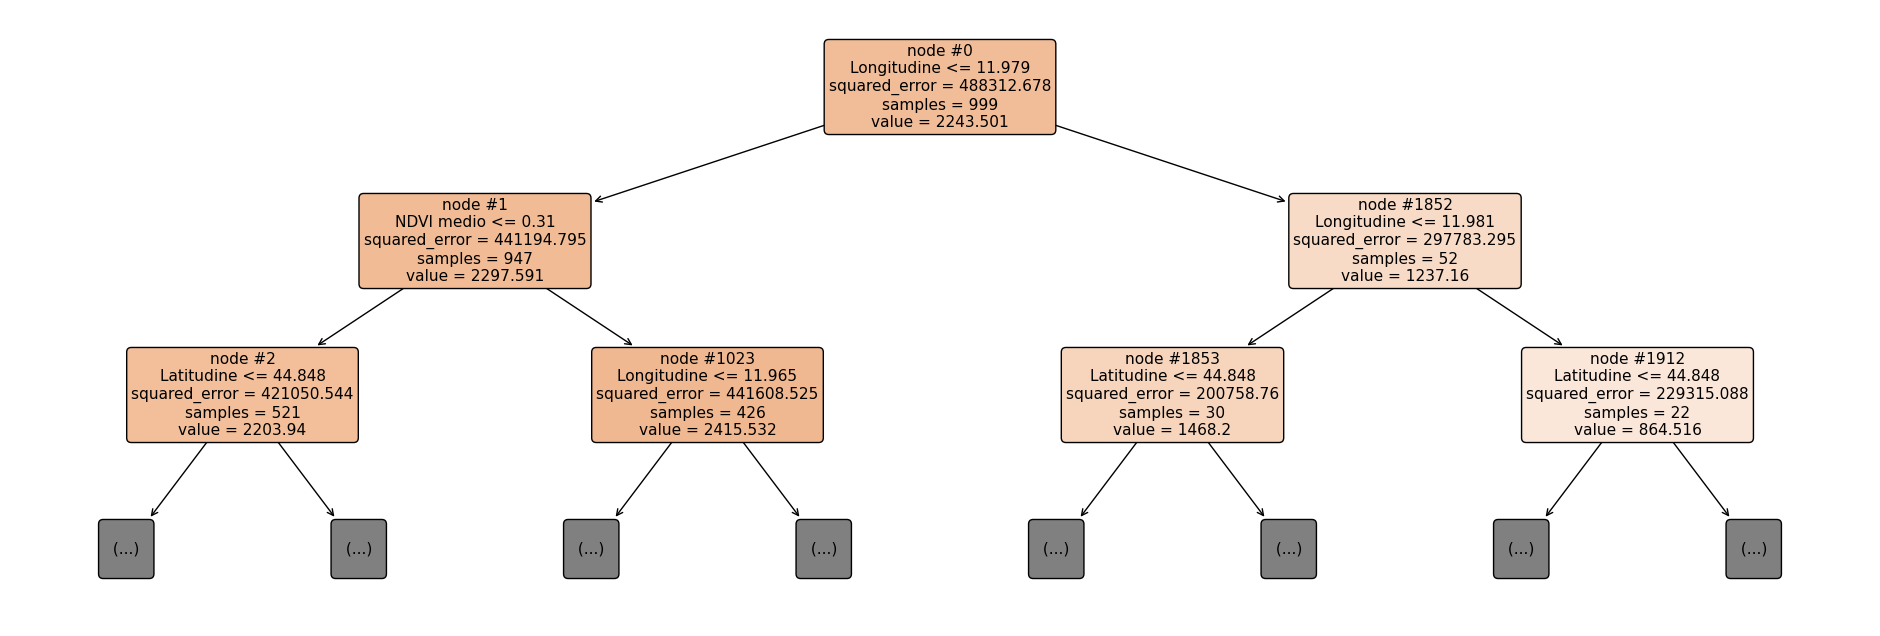

In [87]:
plt.figure(figsize=(24, 8))
plot_tree(modello_scelto.estimators_[0], filled=True, feature_names=X_train.columns, class_names=y_train.unique().astype(str), max_depth=2, node_ids = True, rounded = True)
plt.show()

##### Mostro i primi N alberi fino a una profondità massima P

In [115]:
import math

N = 4 # Funziona solo con N >= 3
fn = X_train.columns
cn = y_train.unique().astype(str)
P = 2

# Calcolo il numero di righe e colonne per i subplot
rows = math.ceil(math.sqrt(N))
cols = math.ceil(N / rows)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10), dpi=900)

# Se N non è un quadrato perfetto, alcune posizioni degli assi potrebbero non essere utilizzate; in tal caso nascondo questi assi
for i in range(rows*cols):
    if i >= N:
        fig.delaxes(axes.flatten()[i])

for i in range(N):
    row = i // cols
    col = i % cols

    plt.sca(axes[row, col])  # Imposto l'asse corrente
    plot_tree(modello_scelto.estimators_[i], filled=True, feature_names=fn, class_names=cn, max_depth=P)
    axes[row, col].set_title('Albero ' + str(i+1), fontsize=11)

# fig.savefig(f'Random forest con {N} alberi.png')

##### Performance della random forest

<h6> Performance sul training set </h6>

In [89]:
print('Performance sul training set:')

predizioni_train = modello_scelto.predict(X_train)


print('\nMSE:')
mse_train = mean_squared_error(y_train, predizioni_train)
print(mse_train)

print('\nMAPE:')
mape_train = mean_absolute_percentage_error(y_train, predizioni_train)
print(f'{round(mape_train*100, 2)}%')

print('\nMAE:')
mae_train = mean_absolute_error(y_train, predizioni_train)
print(mae_train)

print('\nR^2:')
r2_train = r2_score(y_train, predizioni_train)
print(f'{round(r2_train*100, 2)}%')

prime_3_metriche = [mse_train, mape_train, mae_train]

print('\nMedia aritmetica di MSE, MAPE e MAE:')
media_train = np.mean(prime_3_metriche)
print(media_train)

pesi_media_pesata = {
    'MSE': 1,
    'MAPE': 5,
    'MAE': 1
}

print('\nMedia pesata di MSE, MAPE e MAE:')
media_pesata_train = sum(x * w for x, w in zip(prime_3_metriche, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())
print(media_pesata_train)

Performance sul training set:

MSE:
27114.636330467645

MAPE:
9.84%

MAE:
120.43730381646394

R^2:
94.39%

Media aritmetica di MSE, MAPE e MAE:
9078.390682932988

Media pesata di MSE, MAPE e MAE:
3890.7951009797703


<h6> Performance sul validation set </h6>

In [90]:
print('Performance sul validation set:')

predizioni_val = modello_scelto.predict(X_val)


print('\nMSE:')
mse_val = mean_squared_error(y_val, predizioni_val)
print(mse_val)

print('\nMAPE:')
mape_val = mean_absolute_percentage_error(y_val, predizioni_val)
print(f'{round(mape_val*100, 2)}%')

print('\nMAE:')
mae_val = mean_absolute_error(y_val, predizioni_val)
print(mae_val)

print('\nR^2:')
r2_val = r2_score(y_val, predizioni_val)
print(f'{round(r2_val*100, 2)}%')

prime_3_metriche = [mse_val, mape_val, mae_val]

print('\nMedia aritmetica di MSE, MAPE e MAE:')
media_val = np.mean(prime_3_metriche)
print(media_val)

pesi_media_pesata = {
    'MSE': 1,
    'MAPE': 5,
    'MAE': 1
}

print('\nMedia pesata di MSE, MAPE e MAE:')
media_pesata_val = sum(x * w for x, w in zip(prime_3_metriche, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())
print(media_pesata_val)

Performance sul validation set:



MSE:
190455.43567218847

MAPE:
21.67%

MAE:
312.68276549680684

R^2:
60.33%

Media aritmetica di MSE, MAPE e MAE:
63589.44504235842

Media pesata di MSE, MAPE e MAE:
27252.743126376456


<h6> Performance sul test set </h6>

In [91]:
print('Performance sul test set:')

predizioni_test = modello_scelto.predict(X_test)


print('\nMSE:')
mse_test = mean_squared_error(y_test, predizioni_test)
print(mse_test)

print('\nMAPE:')
mape_test = mean_absolute_percentage_error(y_test, predizioni_test)
print(f'{round(mape_test*100, 2)}%')

print('\nMAE:')
mae_test = mean_absolute_error(y_test, predizioni_test)
print(mae_test)

print('\nR^2:')
r2_test = r2_score(y_test, predizioni_test)
print(f'{round(r2_test*100, 2)}%')

prime_3_metriche = [mse_test, mape_test, mae_test]

print('\nMedia aritmetica di MSE, MAPE e MAE:')
media_test = np.mean(prime_3_metriche)
print(media_test)

pesi_media_pesata = {
    'MSE': 1,
    'MAPE': 5,
    'MAE': 1
}

print('\nMedia pesata di MSE, MAPE e MAE:')
media_pesata_test = sum(x * w for x, w in zip(prime_3_metriche, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())
print(media_pesata_test)

Performance sul test set:



MSE:
213280.78454854424

MAPE:
24.1%

MAE:
342.99541139883826

R^2:
60.74%

Media aritmetica di MSE, MAPE e MAE:
71208.00700035239

Media pesata di MSE, MAPE e MAE:
30517.855023644785


<h6> Performance sui dati totali </h6>

In [92]:
print('Performance sui dati totali:')

predizioni = modello_scelto.predict(X)


print('\nMSE:')
mse = mean_squared_error(y, predizioni)
print(mse)

print('\nMAPE:')
mape = mean_absolute_percentage_error(y, predizioni)
print(f'{round(mape*100, 2)}%')

print('\nMAE:')
mae = mean_absolute_error(y, predizioni)
print(mae)

print('\nR^2:')
r2 = r2_score(y, predizioni)
print(f'{round(r2*100, 2)}%')

prime_3_metriche = [mse, mape, mae]

print('\nMedia aritmetica di MSE, MAPE e MAE:')
media = np.mean(prime_3_metriche)
print(media)

pesi_media_pesata = {
    'MSE': 1,
    'MAPE': 5,
    'MAE': 1
}

print('\nMedia pesata di MSE, MAPE e MAE:')
media_pesata = sum(x * w for x, w in zip(prime_3_metriche, pesi_media_pesata.values())) / sum(pesi_media_pesata.values())
print(media_pesata)

Performance sui dati totali:



MSE:
60542.797738442

MAPE:
12.34%

MAE:
160.1271070331553

R^2:
87.63%

Media aritmetica di MSE, MAPE e MAE:
20234.34941695436

Media pesata di MSE, MAPE e MAE:
8671.934553202107


##### Importanza delle features del modello scelto

Importanza delle caratteristiche:
  Caratteristica  Importanza
1    Longitudine      0.7116
2     Latitudine      0.2670
0     NDVI medio      0.0214


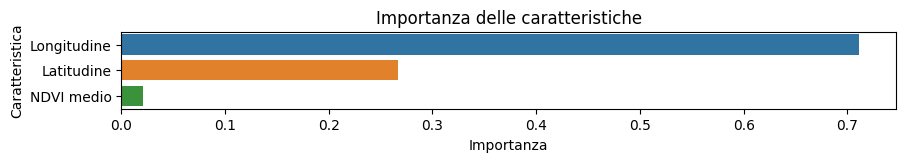

In [93]:
# Imposto il formato di stampa a 4 decimali
pd.set_option('display.float_format', '{:.4f}'.format)

# Estraggo l'importanza delle caratteristiche
feature_importance = modello_scelto.feature_importances_

# Prendo i nomi delle caratteristiche dal dataset
feature_names = X_train.columns

# Creo un DataFrame per la visualizzazione
feature_df = pd.DataFrame({'Caratteristica': feature_names, 'Importanza': feature_importance})

# Ordino le caratteristiche per importanza
feature_df = feature_df.sort_values(by='Importanza', ascending=False)
print('Importanza delle caratteristiche:')
print(feature_df)

# Visualizzo l'importanza delle caratteristiche
plt.figure(figsize=(10, round(len(feature_names)/3)))
sns.barplot(x='Importanza', y='Caratteristica', data=feature_df)
plt.title('Importanza delle caratteristiche')
plt.xlabel('Importanza')
plt.ylabel('Caratteristica')

# percorso_immagine = r"C:\Users\Alessandro\Desktop\Temporanea"
# nome_immagine = f'Importanza delle features per il modello {numero_cartella_scelta}_{numero_modello_scelto}.png'
# percorso_completo_immagine = percorso_immagine + "\\" + nome_immagine

# Salvo l'immagine nel percorso specificato
# plt.savefig(percorso_completo_immagine)

plt.show()

##### Grafico della resa predetta in funzione di quella reale (idealmente una retta inclinata a 45°)

Text(0, 0.5, 'Resa predetta')

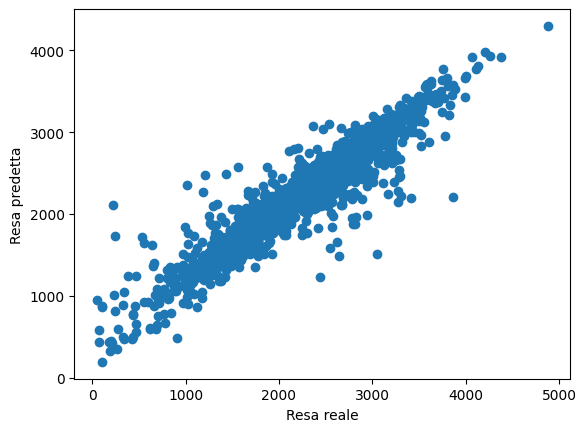

In [94]:
plt.scatter(dati_finali['Resa (kg)'], modello_scelto.predict(dati_finali[['NDVI medio', 'Longitudine', 'Latitudine']]))
plt.xlabel('Resa reale')
plt.ylabel('Resa predetta')